# Tuning BILSTM

In [ ]:
lr :5e-4,1e-4,1e-3
batch_size :32, 64,128
hidden_dim :32,64,128
 epochs = 10,15,20
 dropout:0,0.3,0.5
 optimizer:Adam,SGD
 dim glove:100,300


# lr = 5e-4

Epoch 1: Loss = 35.6859, Train Acc = 0.5453, Dev Acc = 0.6544
Epoch 2: Loss = 31.9788, Train Acc = 0.6934, Dev Acc = 0.7255
Epoch 3: Loss = 26.5710, Train Acc = 0.7552, Dev Acc = 0.7647
Epoch 4: Loss = 21.3120, Train Acc = 0.8280, Dev Acc = 0.7794
Epoch 5: Loss = 19.2062, Train Acc = 0.8617, Dev Acc = 0.7794
Epoch 6: Loss = 13.9544, Train Acc = 0.8947, Dev Acc = 0.7966
Epoch 7: Loss = 10.1172, Train Acc = 0.9333, Dev Acc = 0.7990
Epoch 8: Loss = 8.8375, Train Acc = 0.9382, Dev Acc = 0.7917
Epoch 9: Loss = 5.4714, Train Acc = 0.9712, Dev Acc = 0.7917
Epoch 10: Loss = 3.6964, Train Acc = 0.9810, Dev Acc = 0.7721


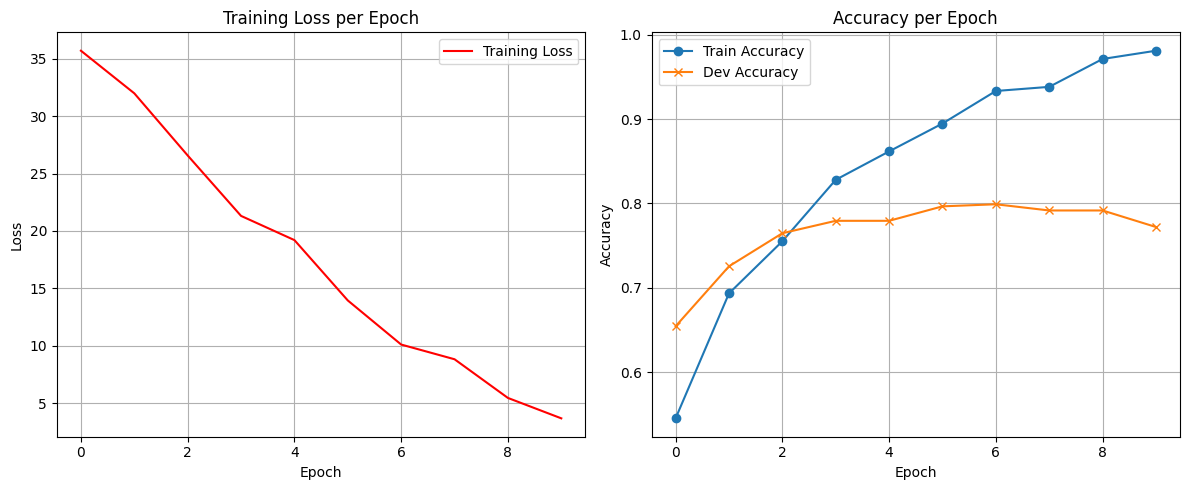


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8993    0.6127    0.7289       204
           1     0.7063    0.9314    0.8034       204

    accuracy                         0.7721       408
   macro avg     0.8028    0.7721    0.7661       408
weighted avg     0.8028    0.7721    0.7661       408

Confusion Matrix:
 [[125  79]
 [ 14 190]]


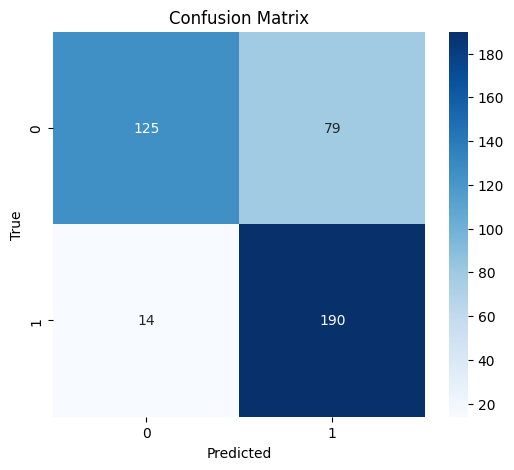


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8500    0.5484    0.6667       341
           1     0.6667    0.9032    0.7671       341

    accuracy                         0.7258       682
   macro avg     0.7583    0.7258    0.7169       682
weighted avg     0.7583    0.7258    0.7169       682

Confusion Matrix:
 [[187 154]
 [ 33 308]]


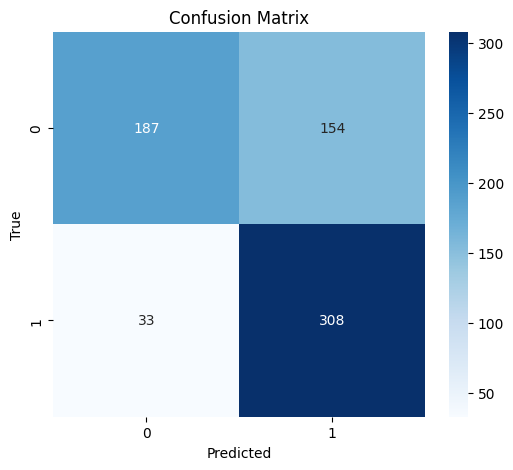

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# lr = 1e-4

Epoch 1: Loss = 36.0643, Train Acc = 0.5165, Dev Acc = 0.5392
Epoch 2: Loss = 35.7078, Train Acc = 0.5569, Dev Acc = 0.6078
Epoch 3: Loss = 35.4745, Train Acc = 0.5930, Dev Acc = 0.6373
Epoch 4: Loss = 35.0650, Train Acc = 0.6285, Dev Acc = 0.6667
Epoch 5: Loss = 34.4478, Train Acc = 0.6701, Dev Acc = 0.6838
Epoch 6: Loss = 33.4482, Train Acc = 0.6885, Dev Acc = 0.6936
Epoch 7: Loss = 31.6016, Train Acc = 0.7081, Dev Acc = 0.7010
Epoch 8: Loss = 29.9412, Train Acc = 0.7240, Dev Acc = 0.6961
Epoch 9: Loss = 28.3338, Train Acc = 0.7534, Dev Acc = 0.7108
Epoch 10: Loss = 26.7173, Train Acc = 0.7662, Dev Acc = 0.7451


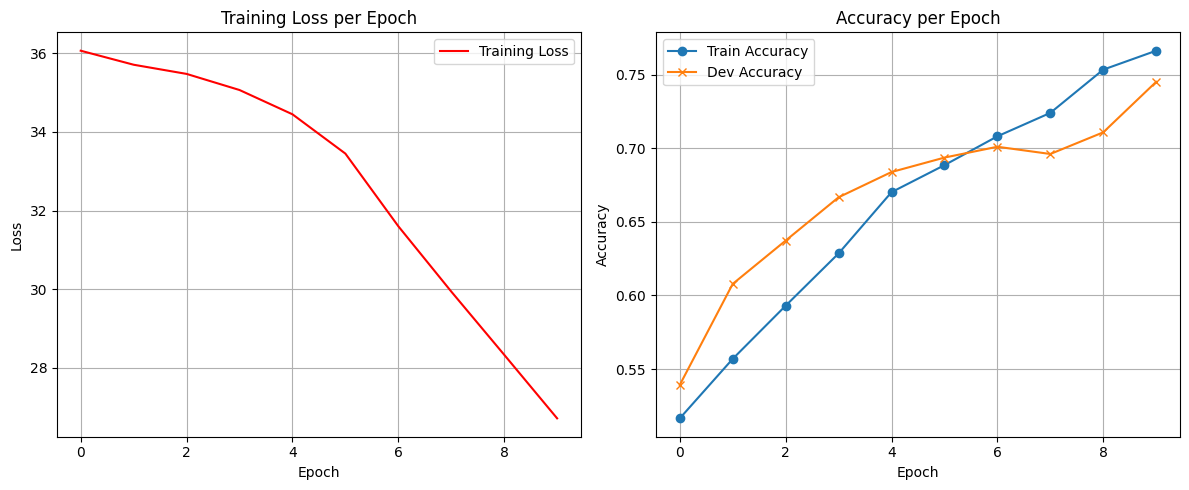


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8165    0.6324    0.7127       204
           1     0.7000    0.8578    0.7709       204

    accuracy                         0.7451       408
   macro avg     0.7582    0.7451    0.7418       408
weighted avg     0.7582    0.7451    0.7418       408

Confusion Matrix:
 [[129  75]
 [ 29 175]]


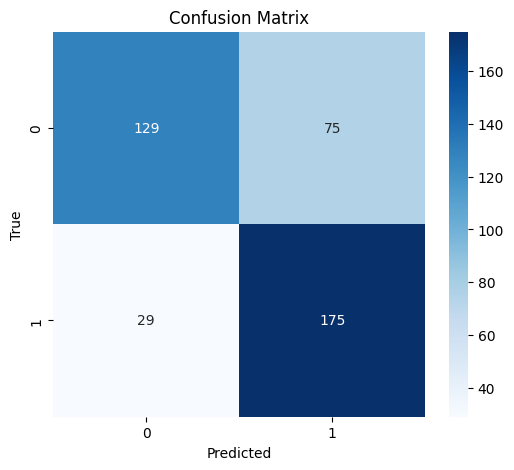


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7652    0.5924    0.6678       341
           1     0.6675    0.8182    0.7352       341

    accuracy                         0.7053       682
   macro avg     0.7163    0.7053    0.7015       682
weighted avg     0.7163    0.7053    0.7015       682

Confusion Matrix:
 [[202 139]
 [ 62 279]]


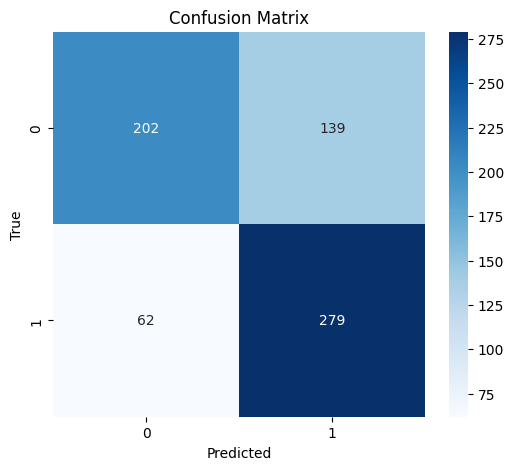

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-4
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# lr = 1e-3

Epoch 1: Loss = 34.9611, Train Acc = 0.5875, Dev Acc = 0.6618
Epoch 2: Loss = 28.0268, Train Acc = 0.7393, Dev Acc = 0.7598
Epoch 3: Loss = 19.6001, Train Acc = 0.8360, Dev Acc = 0.7892
Epoch 4: Loss = 13.0236, Train Acc = 0.9021, Dev Acc = 0.8113
Epoch 5: Loss = 8.2712, Train Acc = 0.9461, Dev Acc = 0.8088
Epoch 6: Loss = 3.8019, Train Acc = 0.9798, Dev Acc = 0.8186
Epoch 7: Loss = 2.7389, Train Acc = 0.9829, Dev Acc = 0.8088
Epoch 8: Loss = 2.0533, Train Acc = 0.9896, Dev Acc = 0.8015
Epoch 9: Loss = 0.7514, Train Acc = 0.9969, Dev Acc = 0.8137
Epoch 10: Loss = 0.3269, Train Acc = 0.9988, Dev Acc = 0.8113


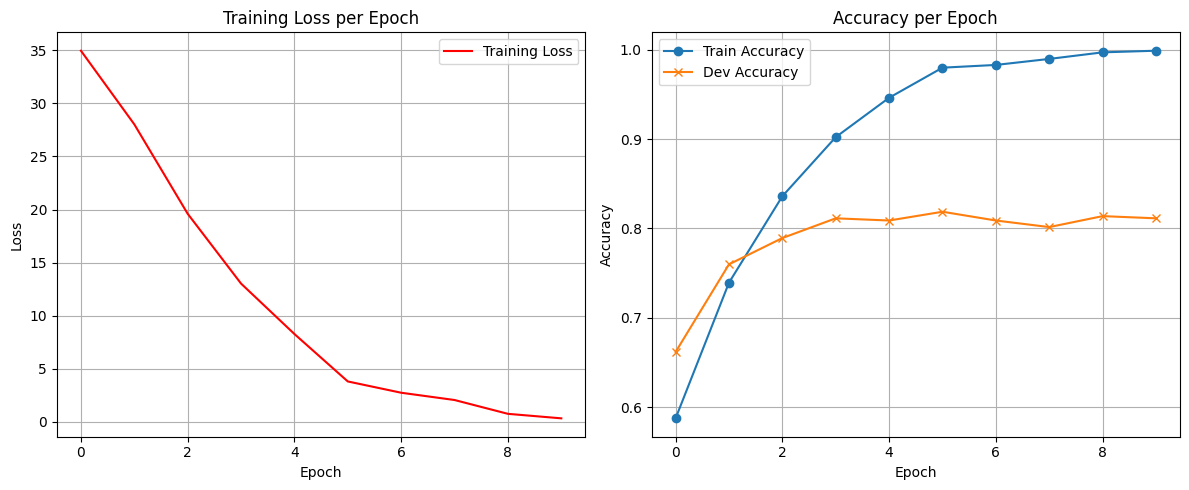


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7822    0.8627    0.8205       204
           1     0.8470    0.7598    0.8010       204

    accuracy                         0.8113       408
   macro avg     0.8146    0.8113    0.8108       408
weighted avg     0.8146    0.8113    0.8108       408

Confusion Matrix:
 [[176  28]
 [ 49 155]]


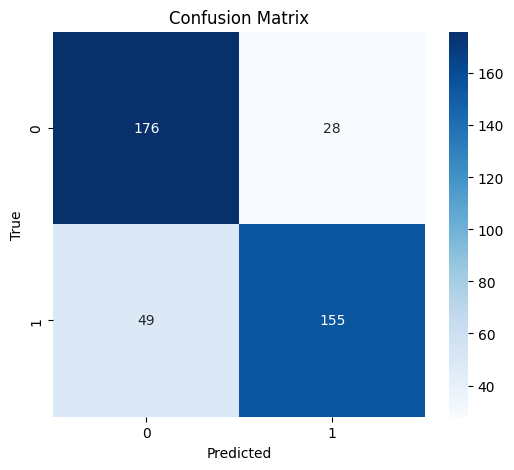


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7382    0.8680    0.7978       341
           1     0.8399    0.6921    0.7588       341

    accuracy                         0.7801       682
   macro avg     0.7890    0.7801    0.7783       682
weighted avg     0.7890    0.7801    0.7783       682

Confusion Matrix:
 [[296  45]
 [105 236]]


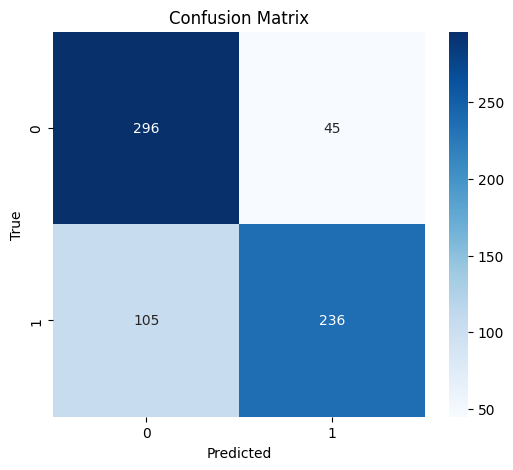

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
#the best is lr = 1e-3


# batch_size = 64

Epoch 1: Loss = 17.8069, Train Acc = 0.5600, Dev Acc = 0.6201
Epoch 2: Loss = 15.9692, Train Acc = 0.6812, Dev Acc = 0.6961
Epoch 3: Loss = 13.3207, Train Acc = 0.7430, Dev Acc = 0.7279
Epoch 4: Loss = 10.2598, Train Acc = 0.8360, Dev Acc = 0.7770
Epoch 5: Loss = 7.7680, Train Acc = 0.8843, Dev Acc = 0.7990
Epoch 6: Loss = 5.2920, Train Acc = 0.9290, Dev Acc = 0.7990
Epoch 7: Loss = 3.9376, Train Acc = 0.9572, Dev Acc = 0.8039
Epoch 8: Loss = 2.3384, Train Acc = 0.9718, Dev Acc = 0.8064
Epoch 9: Loss = 1.4926, Train Acc = 0.9816, Dev Acc = 0.7917
Epoch 10: Loss = 0.8429, Train Acc = 0.9920, Dev Acc = 0.8039


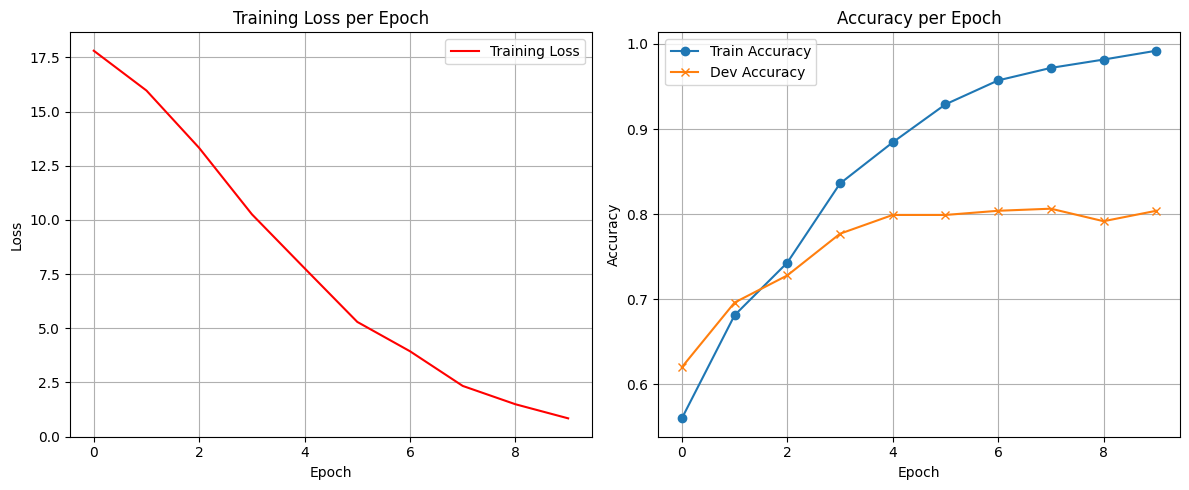


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8407    0.7500    0.7927       204
           1     0.7743    0.8578    0.8140       204

    accuracy                         0.8039       408
   macro avg     0.8075    0.8039    0.8033       408
weighted avg     0.8075    0.8039    0.8033       408

Confusion Matrix:
 [[153  51]
 [ 29 175]]


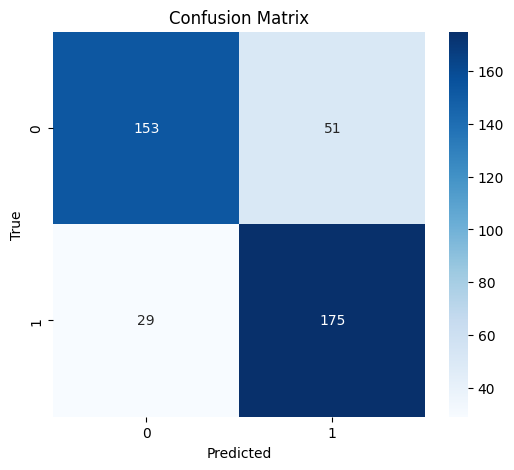


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7956    0.7419    0.7678       341
           1     0.7582    0.8094    0.7830       341

    accuracy                         0.7757       682
   macro avg     0.7769    0.7757    0.7754       682
weighted avg     0.7769    0.7757    0.7754       682

Confusion Matrix:
 [[253  88]
 [ 65 276]]


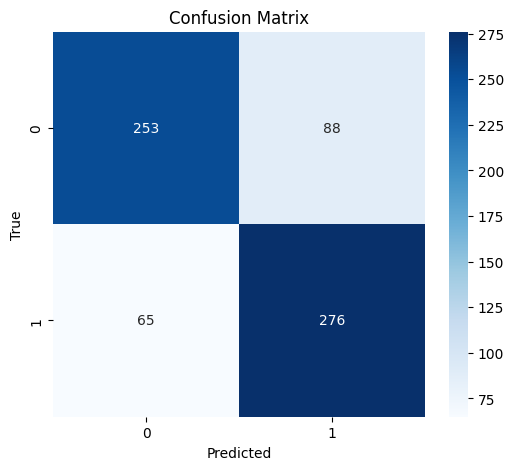

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 64
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#   batch_size = 128


Epoch 1: Loss = 9.0009, Train Acc = 0.5080, Dev Acc = 0.6397
Epoch 2: Loss = 8.6360, Train Acc = 0.6714, Dev Acc = 0.6961
Epoch 3: Loss = 7.6337, Train Acc = 0.7258, Dev Acc = 0.7304
Epoch 4: Loss = 6.3016, Train Acc = 0.7852, Dev Acc = 0.7525
Epoch 5: Loss = 5.3855, Train Acc = 0.8354, Dev Acc = 0.7500
Epoch 6: Loss = 4.3291, Train Acc = 0.8825, Dev Acc = 0.7672
Epoch 7: Loss = 3.5754, Train Acc = 0.8966, Dev Acc = 0.7598
Epoch 8: Loss = 2.7220, Train Acc = 0.9339, Dev Acc = 0.7672
Epoch 9: Loss = 1.9755, Train Acc = 0.9559, Dev Acc = 0.7745
Epoch 10: Loss = 1.5651, Train Acc = 0.9676, Dev Acc = 0.7475


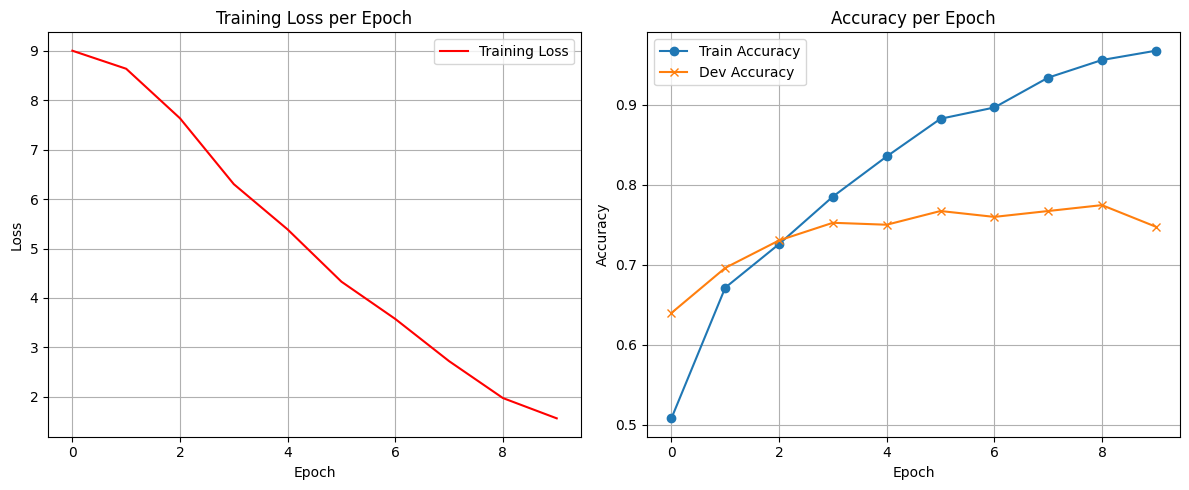


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.6980    0.8725    0.7756       204
           1     0.8301    0.6225    0.7115       204

    accuracy                         0.7475       408
   macro avg     0.7641    0.7475    0.7435       408
weighted avg     0.7641    0.7475    0.7435       408

Confusion Matrix:
 [[178  26]
 [ 77 127]]


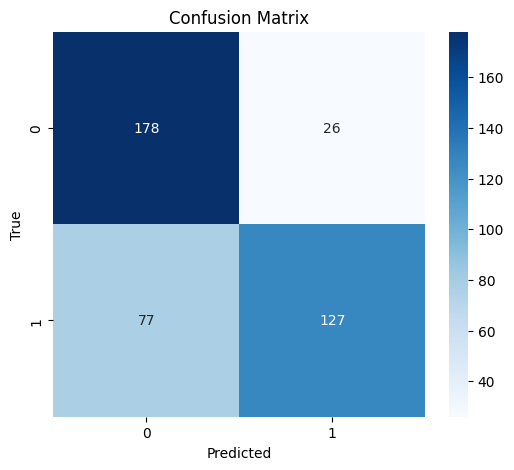


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6900    0.8944    0.7791       341
           1     0.8500    0.5982    0.7022       341

    accuracy                         0.7463       682
   macro avg     0.7700    0.7463    0.7406       682
weighted avg     0.7700    0.7463    0.7406       682

Confusion Matrix:
 [[305  36]
 [137 204]]


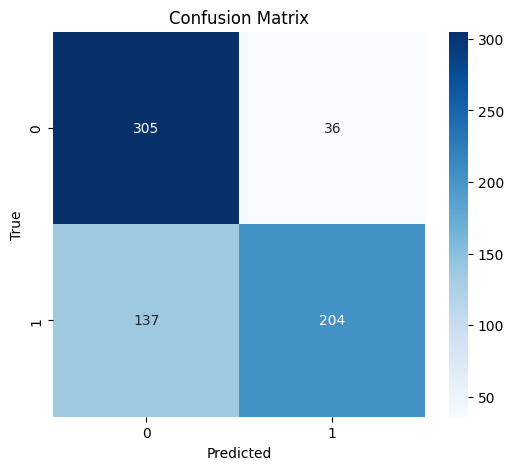

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 128
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
# the best   batch_size = 32


#     hidden_dim = 32


Epoch 1: Loss = 35.6603, Train Acc = 0.5490, Dev Acc = 0.6201
Epoch 2: Loss = 31.4689, Train Acc = 0.7001, Dev Acc = 0.7500
Epoch 3: Loss = 23.9320, Train Acc = 0.7944, Dev Acc = 0.7745
Epoch 4: Loss = 15.7951, Train Acc = 0.8868, Dev Acc = 0.7475
Epoch 5: Loss = 9.0403, Train Acc = 0.9425, Dev Acc = 0.7525
Epoch 6: Loss = 5.5490, Train Acc = 0.9706, Dev Acc = 0.7574
Epoch 7: Loss = 3.4902, Train Acc = 0.9835, Dev Acc = 0.7917
Epoch 8: Loss = 1.8762, Train Acc = 0.9914, Dev Acc = 0.7966
Epoch 9: Loss = 0.8867, Train Acc = 0.9982, Dev Acc = 0.8015
Epoch 10: Loss = 0.5935, Train Acc = 0.9994, Dev Acc = 0.7966


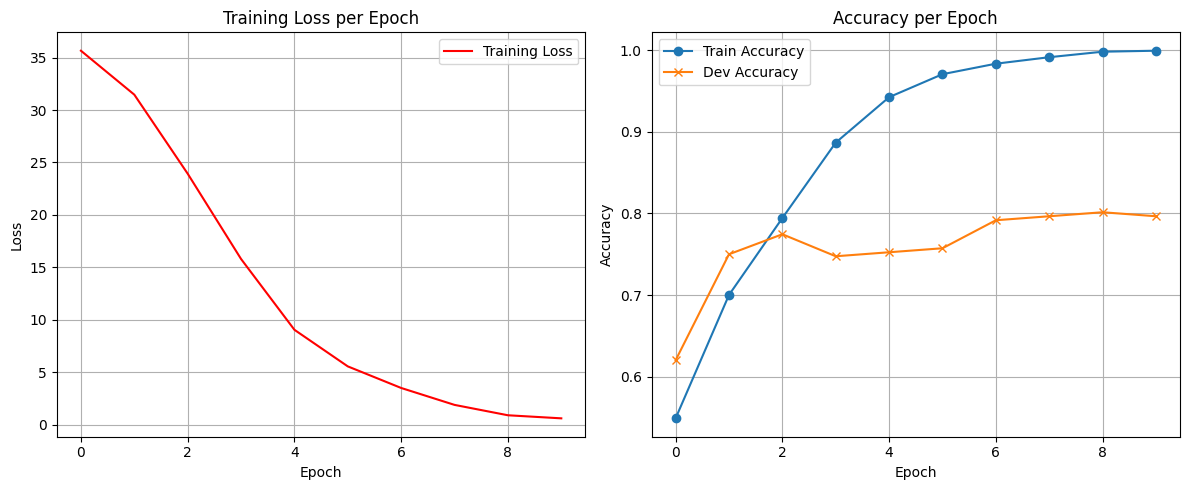


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8457    0.7255    0.7810       204
           1     0.7597    0.8676    0.8101       204

    accuracy                         0.7966       408
   macro avg     0.8027    0.7966    0.7955       408
weighted avg     0.8027    0.7966    0.7955       408

Confusion Matrix:
 [[148  56]
 [ 27 177]]


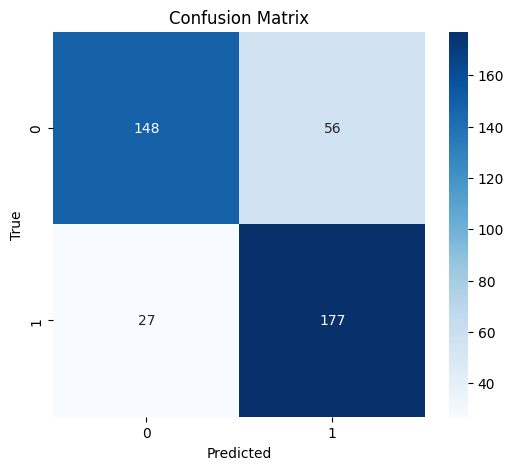


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8219    0.7038    0.7583       341
           1     0.7410    0.8475    0.7907       341

    accuracy                         0.7757       682
   macro avg     0.7815    0.7757    0.7745       682
weighted avg     0.7815    0.7757    0.7745       682

Confusion Matrix:
 [[240 101]
 [ 52 289]]


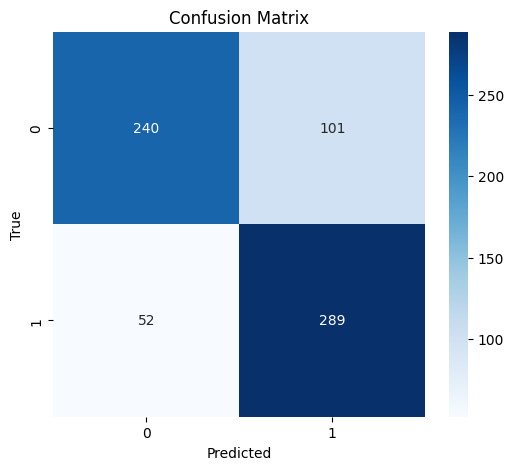

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 32
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#    hidden_dim = 64


Epoch 1: Loss = 34.9171, Train Acc = 0.5930, Dev Acc = 0.6814
Epoch 2: Loss = 29.1321, Train Acc = 0.7191, Dev Acc = 0.7574
Epoch 3: Loss = 22.9275, Train Acc = 0.8244, Dev Acc = 0.7794
Epoch 4: Loss = 15.4046, Train Acc = 0.8947, Dev Acc = 0.7868
Epoch 5: Loss = 8.4332, Train Acc = 0.9437, Dev Acc = 0.7696
Epoch 6: Loss = 4.9381, Train Acc = 0.9780, Dev Acc = 0.7794
Epoch 7: Loss = 2.4636, Train Acc = 0.9896, Dev Acc = 0.7721
Epoch 8: Loss = 1.5697, Train Acc = 0.9914, Dev Acc = 0.7672
Epoch 9: Loss = 0.6641, Train Acc = 0.9988, Dev Acc = 0.7843
Epoch 10: Loss = 0.4543, Train Acc = 0.9982, Dev Acc = 0.7721


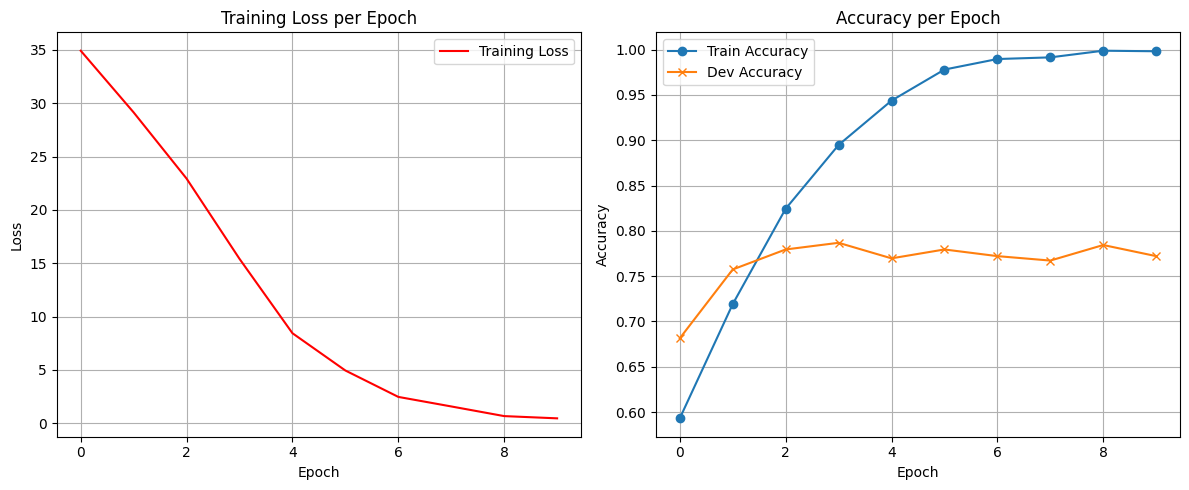


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7284    0.8676    0.7919       204
           1     0.8364    0.6765    0.7480       204

    accuracy                         0.7721       408
   macro avg     0.7824    0.7721    0.7700       408
weighted avg     0.7824    0.7721    0.7700       408

Confusion Matrix:
 [[177  27]
 [ 66 138]]


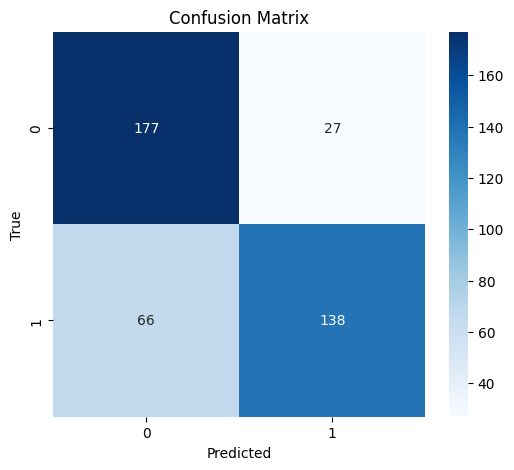


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7000    0.8827    0.7808       341
           1     0.8413    0.6217    0.7150       341

    accuracy                         0.7522       682
   macro avg     0.7706    0.7522    0.7479       682
weighted avg     0.7706    0.7522    0.7479       682

Confusion Matrix:
 [[301  40]
 [129 212]]


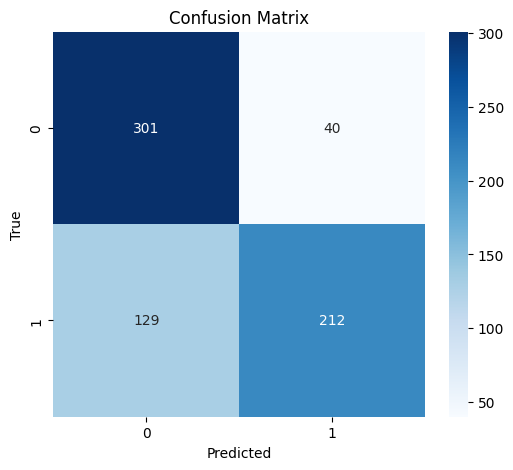

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#     hidden_dim = 128


Epoch 1: Loss = 33.5611, Train Acc = 0.6200, Dev Acc = 0.7181
Epoch 2: Loss = 26.7127, Train Acc = 0.7570, Dev Acc = 0.7574
Epoch 3: Loss = 18.3213, Train Acc = 0.8543, Dev Acc = 0.7794
Epoch 4: Loss = 12.7575, Train Acc = 0.9076, Dev Acc = 0.7475
Epoch 5: Loss = 7.9295, Train Acc = 0.9443, Dev Acc = 0.7966
Epoch 6: Loss = 4.0400, Train Acc = 0.9743, Dev Acc = 0.7770
Epoch 7: Loss = 2.4053, Train Acc = 0.9853, Dev Acc = 0.7721
Epoch 8: Loss = 1.0119, Train Acc = 0.9969, Dev Acc = 0.7672
Epoch 9: Loss = 1.0212, Train Acc = 0.9951, Dev Acc = 0.7770
Epoch 10: Loss = 0.3233, Train Acc = 1.0000, Dev Acc = 0.7696


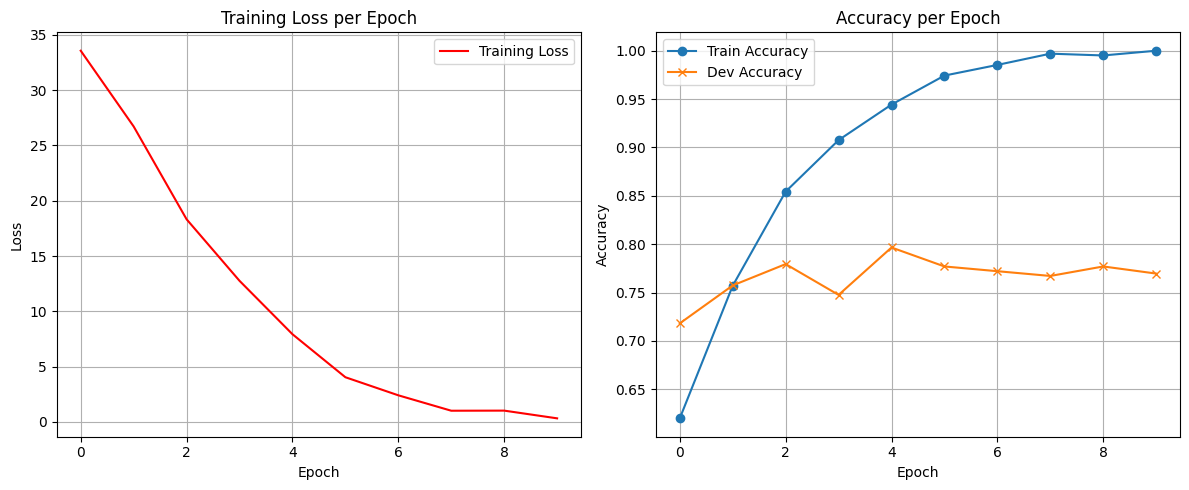


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7331    0.8480    0.7864       204
           1     0.8198    0.6912    0.7500       204

    accuracy                         0.7696       408
   macro avg     0.7764    0.7696    0.7682       408
weighted avg     0.7764    0.7696    0.7682       408

Confusion Matrix:
 [[173  31]
 [ 63 141]]


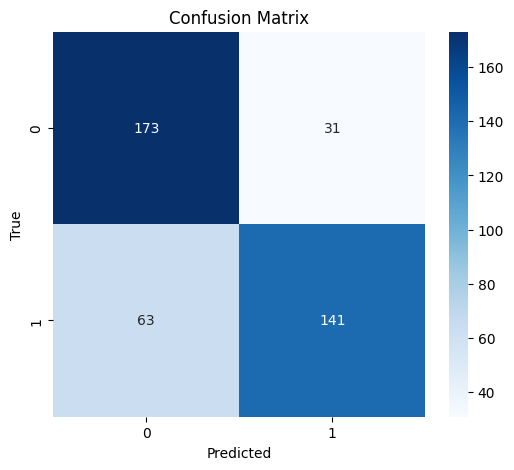


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7126    0.8651    0.7815       341
           1     0.8284    0.6510    0.7291       341

    accuracy                         0.7581       682
   macro avg     0.7705    0.7581    0.7553       682
weighted avg     0.7705    0.7581    0.7553       682

Confusion Matrix:
 [[295  46]
 [119 222]]


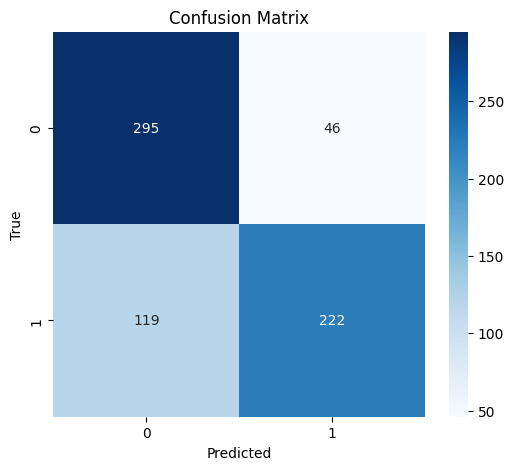

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
# the best  hidden_dim = 64


# epochs = 10

Epoch 1: Loss = 35.6920, Train Acc = 0.5410, Dev Acc = 0.6887
Epoch 2: Loss = 29.0096, Train Acc = 0.7381, Dev Acc = 0.7721
Epoch 3: Loss = 20.6722, Train Acc = 0.8335, Dev Acc = 0.7917
Epoch 4: Loss = 14.4032, Train Acc = 0.8911, Dev Acc = 0.8064
Epoch 5: Loss = 9.8409, Train Acc = 0.9315, Dev Acc = 0.8064
Epoch 6: Loss = 4.7732, Train Acc = 0.9731, Dev Acc = 0.8162
Epoch 7: Loss = 2.8032, Train Acc = 0.9847, Dev Acc = 0.7721
Epoch 8: Loss = 1.5252, Train Acc = 0.9951, Dev Acc = 0.7500
Epoch 9: Loss = 0.9164, Train Acc = 0.9969, Dev Acc = 0.7426
Epoch 10: Loss = 0.4913, Train Acc = 0.9976, Dev Acc = 0.7941


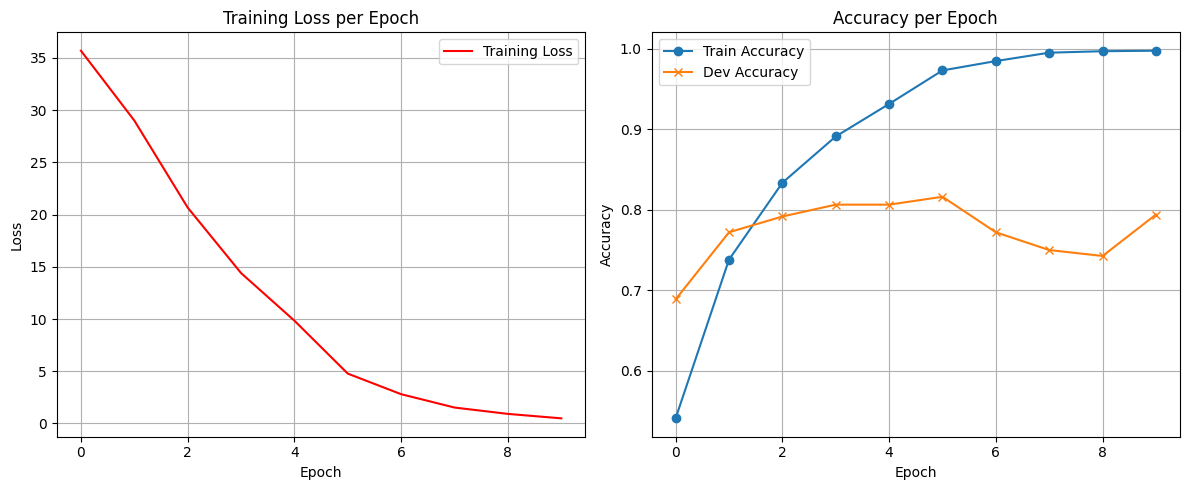


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8488    0.7157    0.7766       204
           1     0.7542    0.8725    0.8091       204

    accuracy                         0.7941       408
   macro avg     0.8015    0.7941    0.7928       408
weighted avg     0.8015    0.7941    0.7928       408

Confusion Matrix:
 [[146  58]
 [ 26 178]]


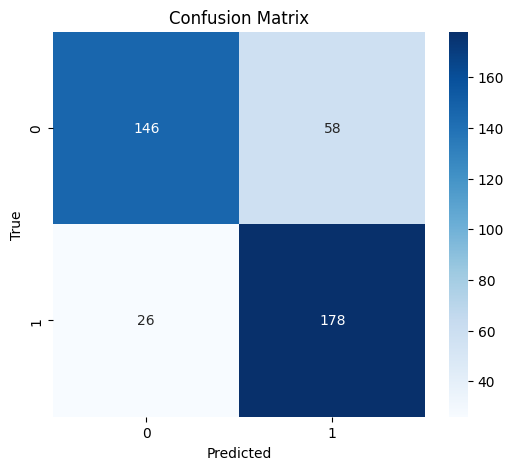


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8351    0.7126    0.7690       341
           1     0.7494    0.8592    0.8005       341

    accuracy                         0.7859       682
   macro avg     0.7922    0.7859    0.7848       682
weighted avg     0.7922    0.7859    0.7848       682

Confusion Matrix:
 [[243  98]
 [ 48 293]]


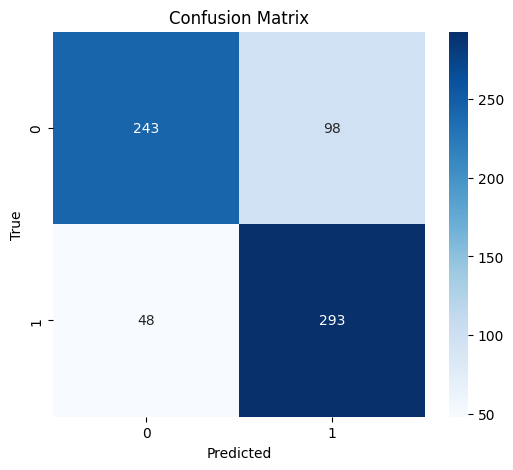

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


epochs = 15

Epoch 1: Loss = 34.5547, Train Acc = 0.5881, Dev Acc = 0.7059
Epoch 2: Loss = 28.1168, Train Acc = 0.7338, Dev Acc = 0.7377
Epoch 3: Loss = 20.7396, Train Acc = 0.8256, Dev Acc = 0.7868
Epoch 4: Loss = 13.9583, Train Acc = 0.8941, Dev Acc = 0.7892
Epoch 5: Loss = 8.1503, Train Acc = 0.9486, Dev Acc = 0.8137
Epoch 6: Loss = 4.8343, Train Acc = 0.9755, Dev Acc = 0.7794
Epoch 7: Loss = 2.2170, Train Acc = 0.9890, Dev Acc = 0.8162
Epoch 8: Loss = 1.1016, Train Acc = 0.9957, Dev Acc = 0.7917
Epoch 9: Loss = 1.1580, Train Acc = 0.9939, Dev Acc = 0.8088
Epoch 10: Loss = 0.3793, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 11: Loss = 0.2086, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 12: Loss = 0.1365, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 13: Loss = 0.0927, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 14: Loss = 0.0697, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 15: Loss = 0.0565, Train Acc = 1.0000, Dev Acc = 0.7819


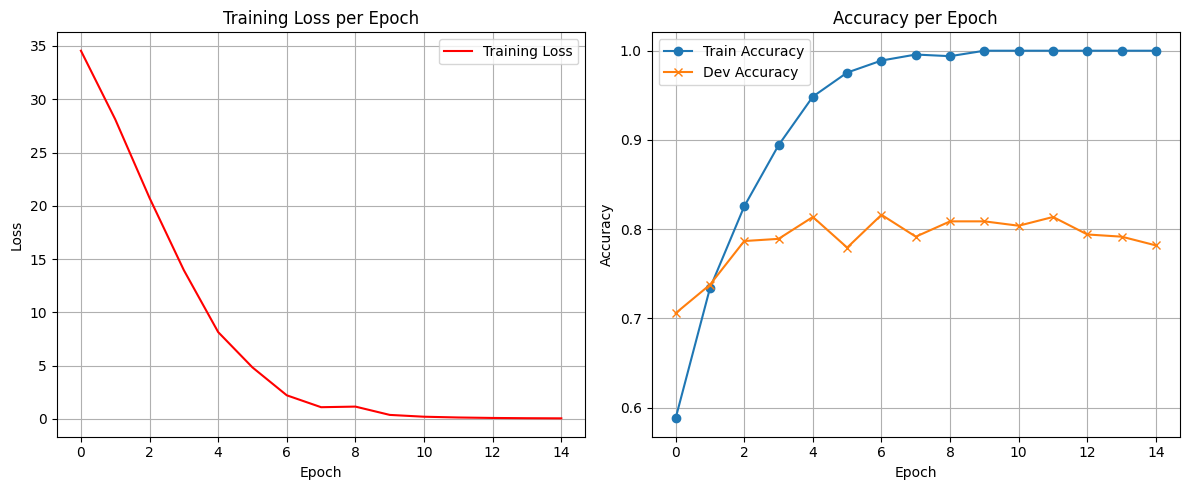


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8010    0.7500    0.7747       204
           1     0.7650    0.8137    0.7886       204

    accuracy                         0.7819       408
   macro avg     0.7830    0.7819    0.7816       408
weighted avg     0.7830    0.7819    0.7816       408

Confusion Matrix:
 [[153  51]
 [ 38 166]]


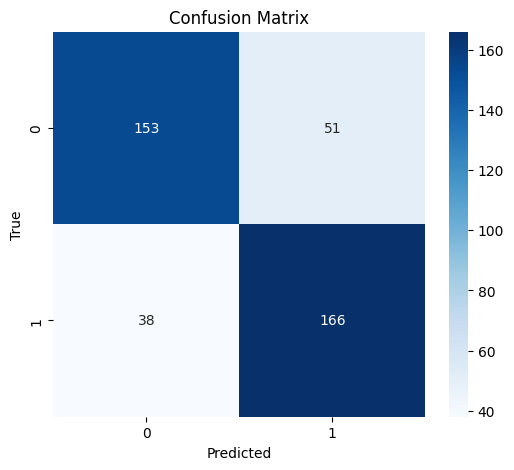


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7791    0.7654    0.7722       341
           1     0.7695    0.7830    0.7762       341

    accuracy                         0.7742       682
   macro avg     0.7743    0.7742    0.7742       682
weighted avg     0.7743    0.7742    0.7742       682

Confusion Matrix:
 [[261  80]
 [ 74 267]]


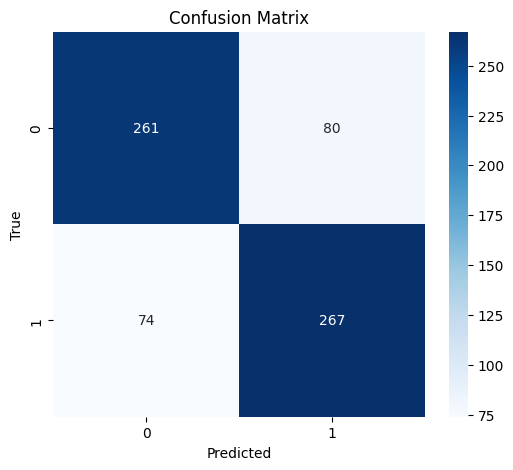

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 15
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# epochs = 20

Epoch 1: Loss = 34.6976, Train Acc = 0.5936, Dev Acc = 0.6740
Epoch 2: Loss = 26.7823, Train Acc = 0.7411, Dev Acc = 0.7255
Epoch 3: Loss = 21.0500, Train Acc = 0.8250, Dev Acc = 0.7819
Epoch 4: Loss = 13.8346, Train Acc = 0.9064, Dev Acc = 0.7794
Epoch 5: Loss = 7.7917, Train Acc = 0.9504, Dev Acc = 0.8039
Epoch 6: Loss = 4.1128, Train Acc = 0.9774, Dev Acc = 0.7794
Epoch 7: Loss = 2.0706, Train Acc = 0.9914, Dev Acc = 0.7966
Epoch 8: Loss = 2.2333, Train Acc = 0.9884, Dev Acc = 0.7672
Epoch 9: Loss = 2.2173, Train Acc = 0.9902, Dev Acc = 0.7819
Epoch 10: Loss = 2.6987, Train Acc = 0.9841, Dev Acc = 0.7941
Epoch 11: Loss = 0.5913, Train Acc = 0.9982, Dev Acc = 0.7990
Epoch 12: Loss = 0.2050, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 13: Loss = 0.2172, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 14: Loss = 0.0998, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 15: Loss = 0.0795, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 16: Loss = 0.0684, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 17: Los

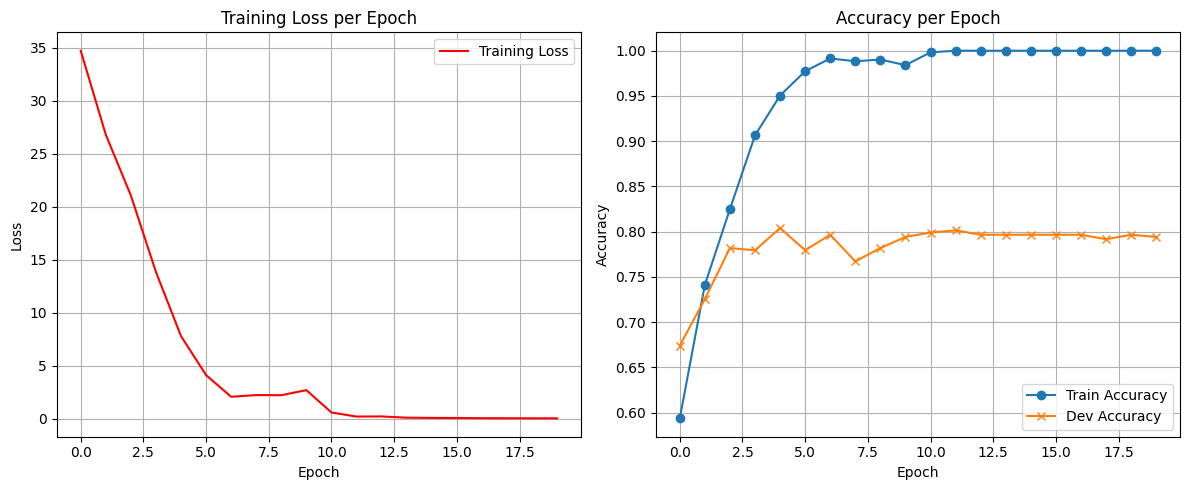


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7586    0.8627    0.8073       204
           1     0.8409    0.7255    0.7789       204

    accuracy                         0.7941       408
   macro avg     0.7998    0.7941    0.7931       408
weighted avg     0.7998    0.7941    0.7931       408

Confusion Matrix:
 [[176  28]
 [ 56 148]]


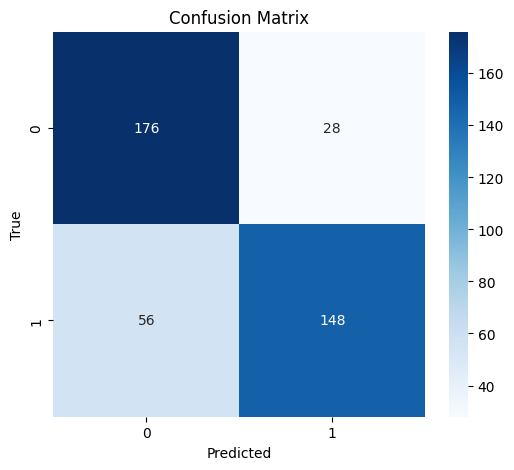


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7293    0.8534    0.7865       341
           1     0.8233    0.6833    0.7468       341

    accuracy                         0.7683       682
   macro avg     0.7763    0.7683    0.7666       682
weighted avg     0.7763    0.7683    0.7666       682

Confusion Matrix:
 [[291  50]
 [108 233]]


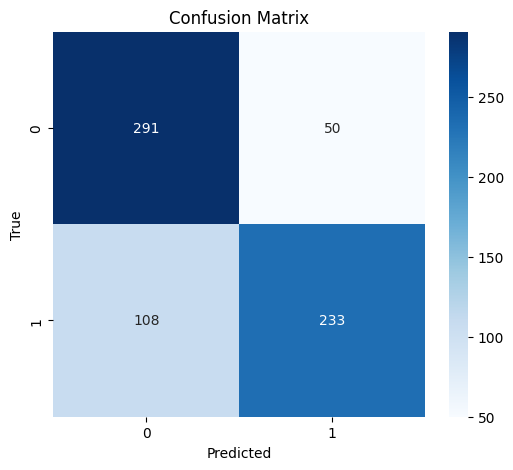

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
# the best epochs = 20


# dropout=0

Epoch 1: Loss = 34.4751, Train Acc = 0.6059, Dev Acc = 0.6765
Epoch 2: Loss = 26.2970, Train Acc = 0.7576, Dev Acc = 0.7549
Epoch 3: Loss = 18.2420, Train Acc = 0.8568, Dev Acc = 0.7770
Epoch 4: Loss = 11.0677, Train Acc = 0.9302, Dev Acc = 0.8088
Epoch 5: Loss = 5.8807, Train Acc = 0.9670, Dev Acc = 0.7794
Epoch 6: Loss = 3.6765, Train Acc = 0.9804, Dev Acc = 0.7917
Epoch 7: Loss = 1.5697, Train Acc = 0.9939, Dev Acc = 0.7990
Epoch 8: Loss = 0.6647, Train Acc = 0.9982, Dev Acc = 0.7696
Epoch 9: Loss = 0.6415, Train Acc = 0.9988, Dev Acc = 0.7941
Epoch 10: Loss = 0.6368, Train Acc = 0.9957, Dev Acc = 0.7941
Epoch 11: Loss = 0.2205, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 12: Loss = 0.1268, Train Acc = 1.0000, Dev Acc = 0.8064
Epoch 13: Loss = 0.0817, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 14: Loss = 0.0636, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 15: Loss = 0.0521, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 16: Loss = 0.0437, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 17: Los

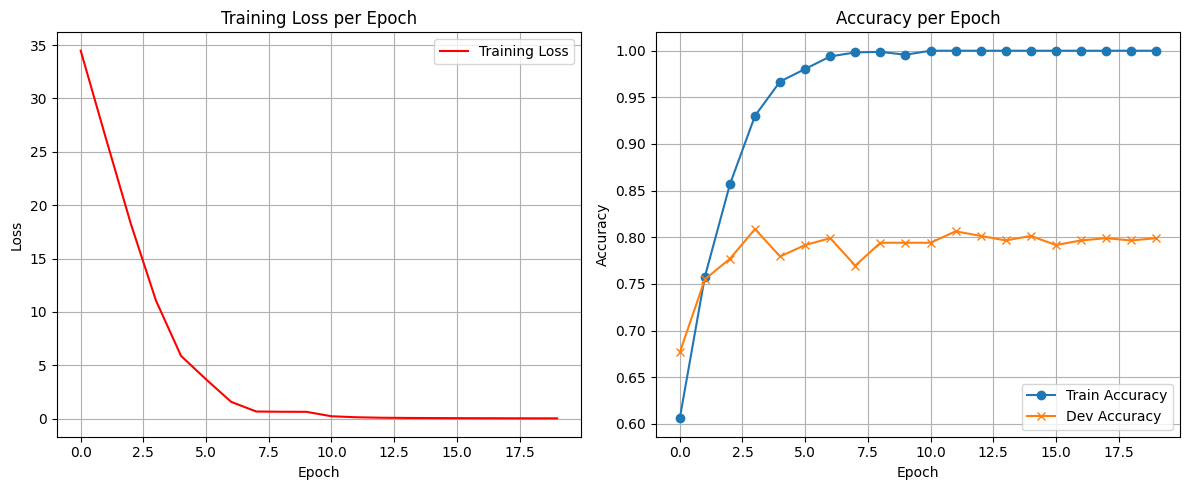


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8315    0.7500    0.7887       204
           1     0.7723    0.8480    0.8084       204

    accuracy                         0.7990       408
   macro avg     0.8019    0.7990    0.7985       408
weighted avg     0.8019    0.7990    0.7985       408

Confusion Matrix:
 [[153  51]
 [ 31 173]]


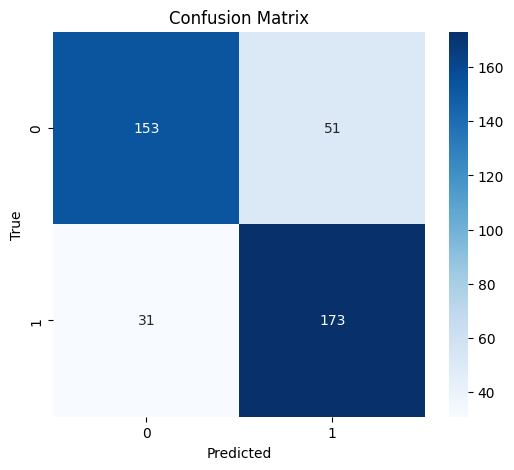


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8043    0.7595    0.7813       341
           1     0.7722    0.8152    0.7932       341

    accuracy                         0.7874       682
   macro avg     0.7883    0.7874    0.7872       682
weighted avg     0.7883    0.7874    0.7872       682

Confusion Matrix:
 [[259  82]
 [ 63 278]]


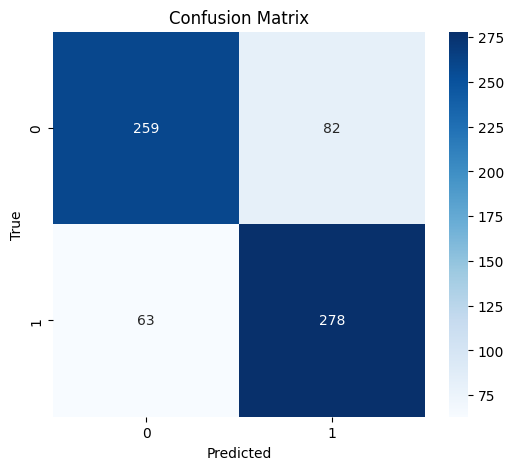

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# dropout = 0.3


Epoch 1: Loss = 35.1353, Train Acc = 0.5722, Dev Acc = 0.6691
Epoch 2: Loss = 27.9102, Train Acc = 0.7436, Dev Acc = 0.7500
Epoch 3: Loss = 19.7465, Train Acc = 0.8384, Dev Acc = 0.7941
Epoch 4: Loss = 12.0664, Train Acc = 0.9113, Dev Acc = 0.8113
Epoch 5: Loss = 7.4765, Train Acc = 0.9529, Dev Acc = 0.7843
Epoch 6: Loss = 4.2572, Train Acc = 0.9761, Dev Acc = 0.7917
Epoch 7: Loss = 2.0586, Train Acc = 0.9884, Dev Acc = 0.7623
Epoch 8: Loss = 1.3968, Train Acc = 0.9939, Dev Acc = 0.7917
Epoch 9: Loss = 0.6387, Train Acc = 0.9976, Dev Acc = 0.7770
Epoch 10: Loss = 0.3193, Train Acc = 0.9994, Dev Acc = 0.7745
Epoch 11: Loss = 0.1688, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 12: Loss = 0.1250, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 13: Loss = 0.0965, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 14: Loss = 0.0730, Train Acc = 1.0000, Dev Acc = 0.7794
Epoch 15: Loss = 0.0551, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 16: Loss = 0.0493, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 17: Los

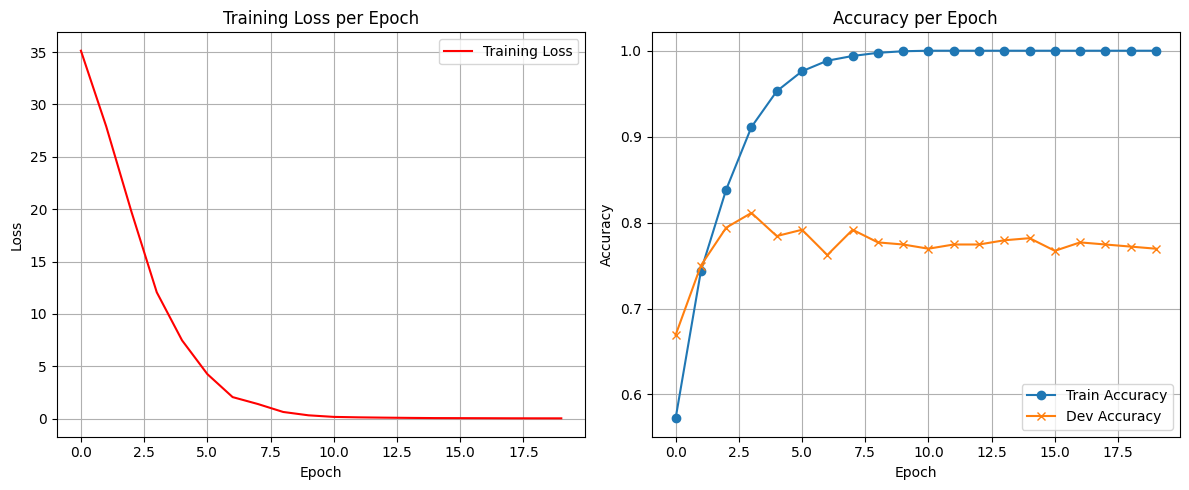


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8438    0.6618    0.7418       204
           1     0.7218    0.8775    0.7920       204

    accuracy                         0.7696       408
   macro avg     0.7828    0.7696    0.7669       408
weighted avg     0.7828    0.7696    0.7669       408

Confusion Matrix:
 [[135  69]
 [ 25 179]]


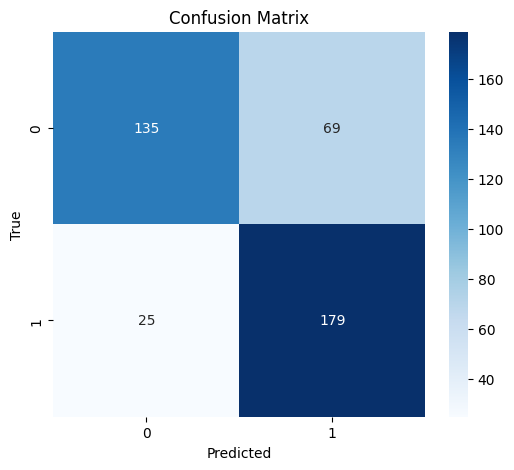


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8149    0.6716    0.7363       341
           1     0.7207    0.8475    0.7790       341

    accuracy                         0.7595       682
   macro avg     0.7678    0.7595    0.7577       682
weighted avg     0.7678    0.7595    0.7577       682

Confusion Matrix:
 [[229 112]
 [ 52 289]]


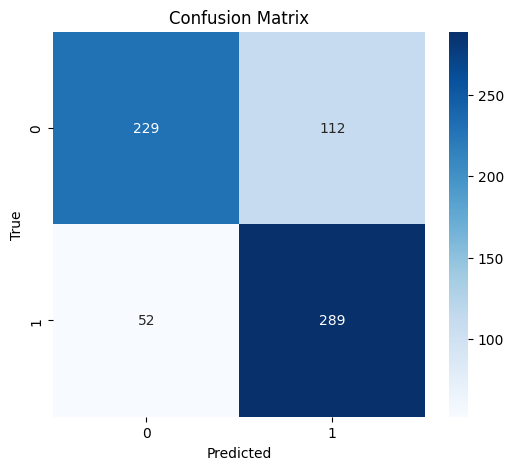

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0.3
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# dropout = 0.5


Epoch 1: Loss = 35.0288, Train Acc = 0.5704, Dev Acc = 0.6544
Epoch 2: Loss = 30.8201, Train Acc = 0.6922, Dev Acc = 0.7230
Epoch 3: Loss = 23.8422, Train Acc = 0.8005, Dev Acc = 0.7892
Epoch 4: Loss = 16.8846, Train Acc = 0.8782, Dev Acc = 0.7966
Epoch 5: Loss = 9.8663, Train Acc = 0.9412, Dev Acc = 0.7941
Epoch 6: Loss = 8.2931, Train Acc = 0.9492, Dev Acc = 0.8113
Epoch 7: Loss = 3.9962, Train Acc = 0.9841, Dev Acc = 0.7917
Epoch 8: Loss = 1.5006, Train Acc = 0.9957, Dev Acc = 0.7892
Epoch 9: Loss = 0.7430, Train Acc = 0.9982, Dev Acc = 0.7868
Epoch 10: Loss = 0.5344, Train Acc = 0.9988, Dev Acc = 0.7941
Epoch 11: Loss = 0.2439, Train Acc = 1.0000, Dev Acc = 0.7892
Epoch 12: Loss = 0.1738, Train Acc = 1.0000, Dev Acc = 0.7843
Epoch 13: Loss = 0.1337, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 14: Loss = 0.1002, Train Acc = 1.0000, Dev Acc = 0.7966
Epoch 15: Loss = 0.0896, Train Acc = 1.0000, Dev Acc = 0.7941
Epoch 16: Loss = 0.0784, Train Acc = 1.0000, Dev Acc = 0.7892
Epoch 17: Los

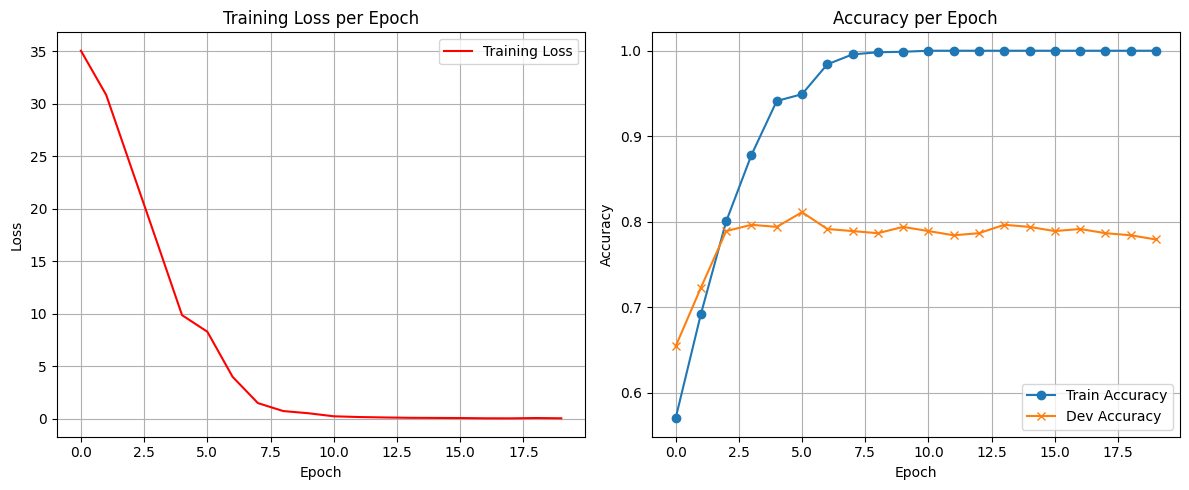


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8314    0.7010    0.7606       204
           1     0.7415    0.8578    0.7955       204

    accuracy                         0.7794       408
   macro avg     0.7865    0.7794    0.7780       408
weighted avg     0.7865    0.7794    0.7780       408

Confusion Matrix:
 [[143  61]
 [ 29 175]]


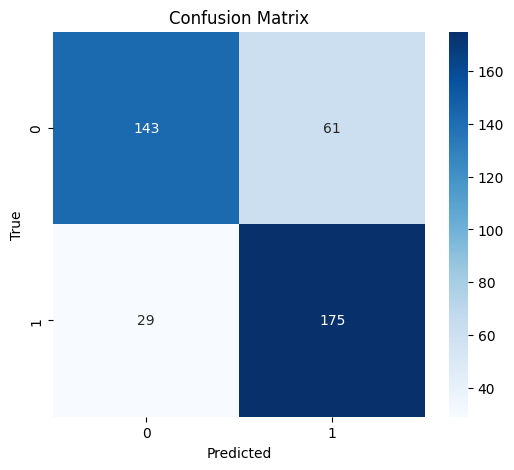


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8255    0.7214    0.7700       341
           1     0.7526    0.8475    0.7972       341

    accuracy                         0.7845       682
   macro avg     0.7891    0.7845    0.7836       682
weighted avg     0.7891    0.7845    0.7836       682

Confusion Matrix:
 [[246  95]
 [ 52 289]]


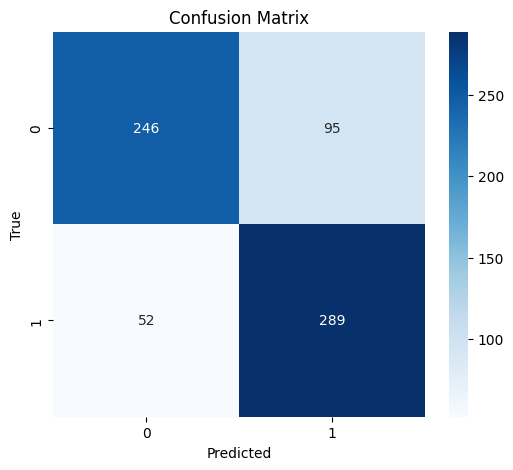

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0.5
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#    optimizer_name = "SGD"


Epoch 1: Loss = 36.3331, Train Acc = 0.4994, Dev Acc = 0.5000
Epoch 2: Loss = 36.2709, Train Acc = 0.4994, Dev Acc = 0.5000
Epoch 3: Loss = 36.1408, Train Acc = 0.4994, Dev Acc = 0.5000
Epoch 4: Loss = 36.1778, Train Acc = 0.4994, Dev Acc = 0.5000
Epoch 5: Loss = 36.0796, Train Acc = 0.4994, Dev Acc = 0.5000
Epoch 6: Loss = 36.1466, Train Acc = 0.5000, Dev Acc = 0.5000
Epoch 7: Loss = 36.0862, Train Acc = 0.5006, Dev Acc = 0.5000
Epoch 8: Loss = 36.1279, Train Acc = 0.5012, Dev Acc = 0.4975
Epoch 9: Loss = 36.0357, Train Acc = 0.5031, Dev Acc = 0.4975
Epoch 10: Loss = 36.0407, Train Acc = 0.5031, Dev Acc = 0.4975
Epoch 11: Loss = 36.0618, Train Acc = 0.5037, Dev Acc = 0.4951
Epoch 12: Loss = 36.0064, Train Acc = 0.5049, Dev Acc = 0.4975
Epoch 13: Loss = 35.9997, Train Acc = 0.5061, Dev Acc = 0.5000
Epoch 14: Loss = 36.0121, Train Acc = 0.5104, Dev Acc = 0.5025
Epoch 15: Loss = 35.9653, Train Acc = 0.5147, Dev Acc = 0.5025
Epoch 16: Loss = 35.9746, Train Acc = 0.5135, Dev Acc = 0.5000
E

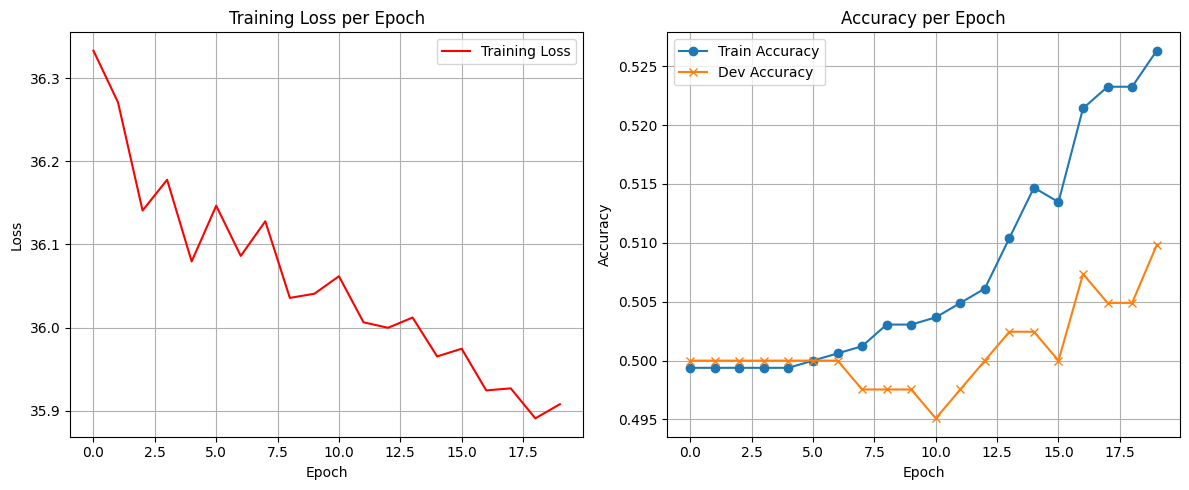


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.5769    0.0735    0.1304       204
           1     0.5052    0.9461    0.6587       204

    accuracy                         0.5098       408
   macro avg     0.5411    0.5098    0.3946       408
weighted avg     0.5411    0.5098    0.3946       408

Confusion Matrix:
 [[ 15 189]
 [ 11 193]]


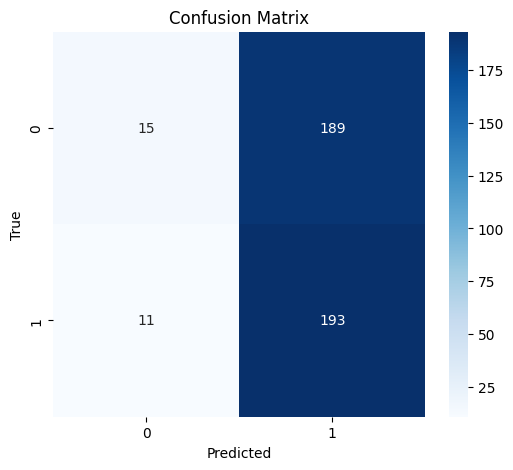


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.5116    0.0645    0.1146       341
           1     0.5008    0.9384    0.6531       341

    accuracy                         0.5015       682
   macro avg     0.5062    0.5015    0.3838       682
weighted avg     0.5062    0.5015    0.3838       682

Confusion Matrix:
 [[ 22 319]
 [ 21 320]]


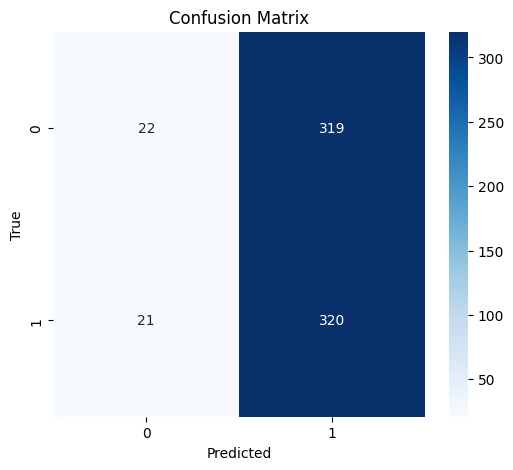

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0
    use_bilstm = True
    optimizer_name = "SGD"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#    optimizer_name = "Adam"


Epoch 1: Loss = 34.7268, Train Acc = 0.5771, Dev Acc = 0.6225
Epoch 2: Loss = 27.8788, Train Acc = 0.7277, Dev Acc = 0.7328
Epoch 3: Loss = 20.5182, Train Acc = 0.8397, Dev Acc = 0.7892
Epoch 4: Loss = 12.2193, Train Acc = 0.9100, Dev Acc = 0.7770
Epoch 5: Loss = 7.1975, Train Acc = 0.9602, Dev Acc = 0.7770
Epoch 6: Loss = 3.9355, Train Acc = 0.9792, Dev Acc = 0.7917
Epoch 7: Loss = 2.2586, Train Acc = 0.9884, Dev Acc = 0.7745
Epoch 8: Loss = 1.2217, Train Acc = 0.9945, Dev Acc = 0.8039
Epoch 9: Loss = 1.1882, Train Acc = 0.9957, Dev Acc = 0.7892
Epoch 10: Loss = 0.3537, Train Acc = 0.9988, Dev Acc = 0.7696
Epoch 11: Loss = 0.1651, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 12: Loss = 0.1347, Train Acc = 1.0000, Dev Acc = 0.7475
Epoch 13: Loss = 0.3346, Train Acc = 0.9988, Dev Acc = 0.7819
Epoch 14: Loss = 0.1073, Train Acc = 1.0000, Dev Acc = 0.7917
Epoch 15: Loss = 0.0636, Train Acc = 1.0000, Dev Acc = 0.7892
Epoch 16: Loss = 0.0511, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 17: Los

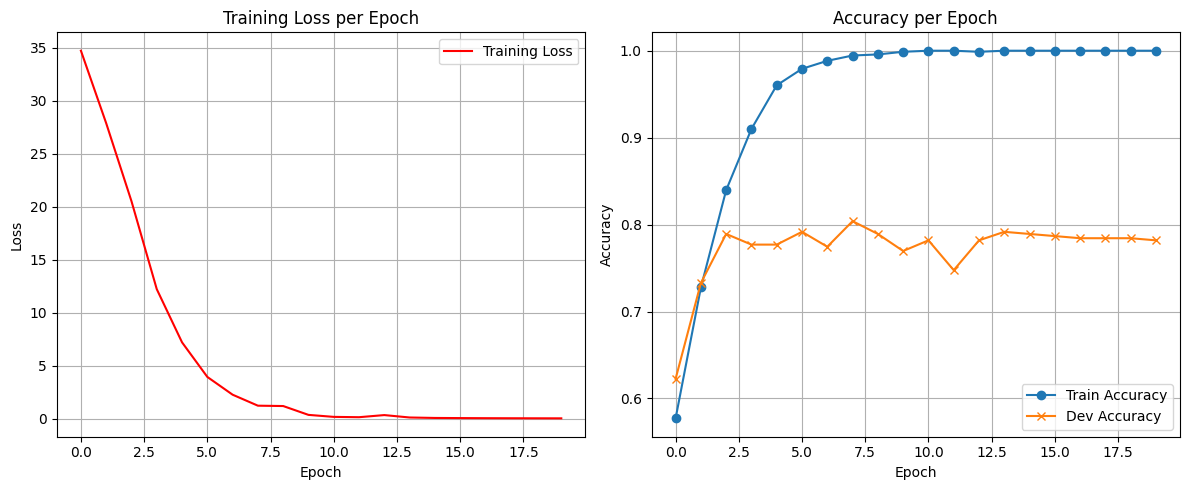


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7511    0.8431    0.7945       204
           1     0.8212    0.7206    0.7676       204

    accuracy                         0.7819       408
   macro avg     0.7862    0.7819    0.7810       408
weighted avg     0.7862    0.7819    0.7810       408

Confusion Matrix:
 [[172  32]
 [ 57 147]]


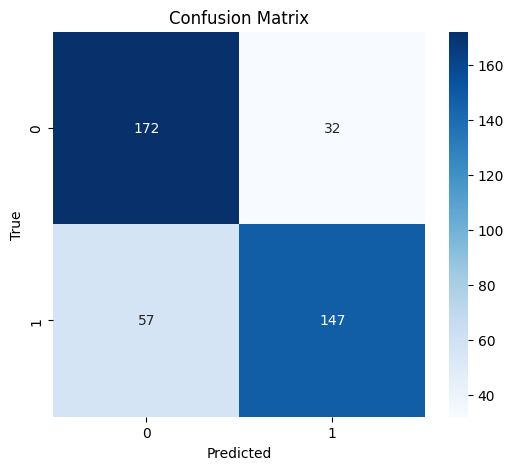


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7357    0.8651    0.7951       341
           1     0.8363    0.6891    0.7556       341

    accuracy                         0.7771       682
   macro avg     0.7860    0.7771    0.7754       682
weighted avg     0.7860    0.7771    0.7754       682

Confusion Matrix:
 [[295  46]
 [106 235]]


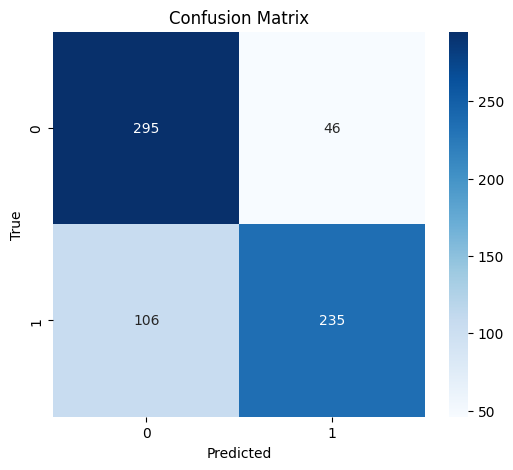

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
# the best optimizer_name = "Adam"


Epoch 1: Loss = 33.7668, Train Acc = 0.6285, Dev Acc = 0.7500
Epoch 2: Loss = 21.8920, Train Acc = 0.8213, Dev Acc = 0.7819
Epoch 3: Loss = 11.8778, Train Acc = 0.9082, Dev Acc = 0.7990
Epoch 4: Loss = 4.3610, Train Acc = 0.9792, Dev Acc = 0.8162
Epoch 5: Loss = 1.9658, Train Acc = 0.9902, Dev Acc = 0.8015
Epoch 6: Loss = 0.8826, Train Acc = 0.9976, Dev Acc = 0.8015
Epoch 7: Loss = 0.2373, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 8: Loss = 0.1217, Train Acc = 1.0000, Dev Acc = 0.8015
Epoch 9: Loss = 0.0826, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 10: Loss = 0.0580, Train Acc = 1.0000, Dev Acc = 0.8039
Epoch 11: Loss = 0.0443, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 12: Loss = 0.0358, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 13: Loss = 0.0464, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 14: Loss = 0.0236, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 15: Loss = 0.0201, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 16: Loss = 0.0174, Train Acc = 1.0000, Dev Acc = 0.8088
Epoch 17: Loss

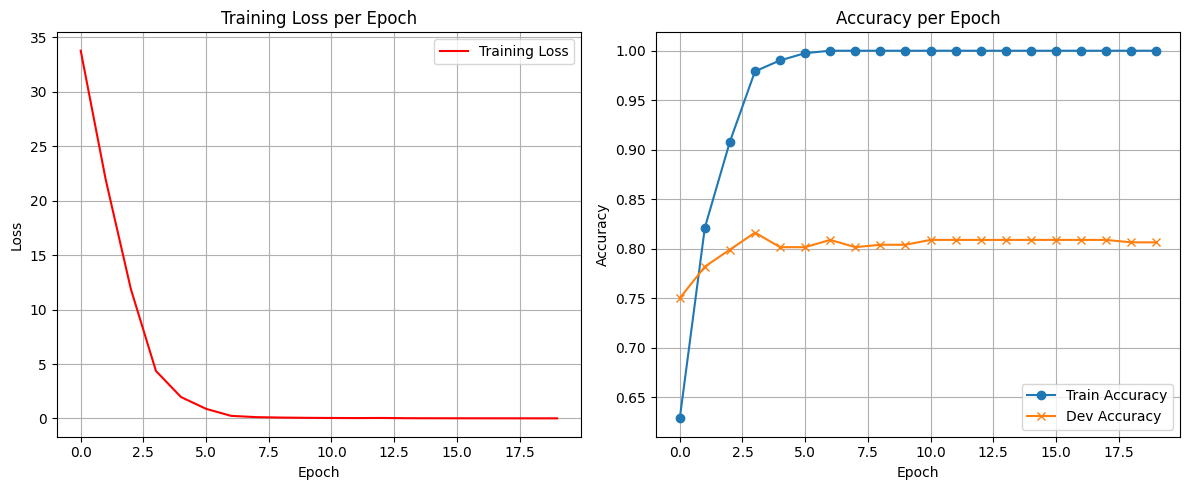


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8453    0.7500    0.7948       204
           1     0.7753    0.8627    0.8167       204

    accuracy                         0.8064       408
   macro avg     0.8103    0.8064    0.8058       408
weighted avg     0.8103    0.8064    0.8058       408

Confusion Matrix:
 [[153  51]
 [ 28 176]]


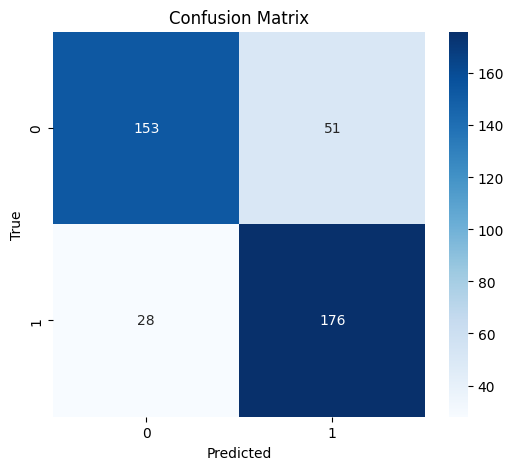


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8215    0.7155    0.7649       341
           1     0.7481    0.8446    0.7934       341

    accuracy                         0.7801       682
   macro avg     0.7848    0.7801    0.7791       682
weighted avg     0.7848    0.7801    0.7791       682

Confusion Matrix:
 [[244  97]
 [ 53 288]]


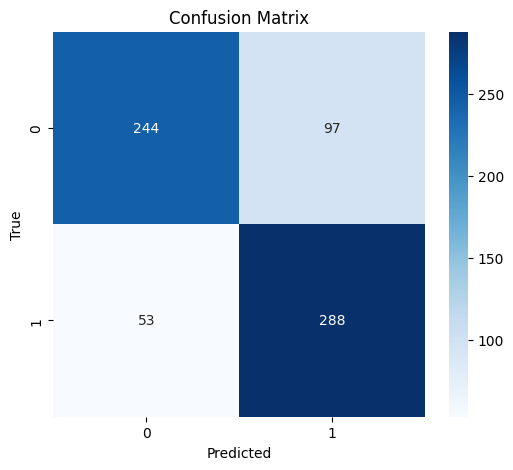

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # 📊 Visualization
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "/content/glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0
    use_bilstm = True
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                        embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# BiLstm with Att_tuning

# lr = 1e-3

In [ ]:
!pip install --upgrade sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 31.5969, Train Acc = 0.6714, Dev Acc = 0.7451
Epoch 2: Loss = 20.0319, Train Acc = 0.8403, Dev Acc = 0.7966
Epoch 3: Loss = 10.0036, Train Acc = 0.9308, Dev Acc = 0.8113
Epoch 4: Loss = 4.7339, Train Acc = 0.9774, Dev Acc = 0.7843
Epoch 5: Loss = 1.7046, Train Acc = 0.9933, Dev Acc = 0.7917
Epoch 6: Loss = 0.7776, Train Acc = 0.9982, Dev Acc = 0.8039
Epoch 7: Loss = 0.5995, Train Acc = 0.9982, Dev Acc = 0.7917
Epoch 8: Loss = 0.4159, Train Acc = 0.9994, Dev Acc = 0.7892
Epoch 9: Loss = 0.1678, Train Acc = 0.9994, Dev Acc = 0.7917
Epoch 10: Loss = 0.1071, Train Acc = 1.0000, Dev Acc = 0.7819
Epoch 11: Loss = 0.0655, Train Acc = 1.0000, Dev Acc = 0.7770
Epoch 12: Loss = 0.0508, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 13: Loss = 0.0406, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 14: Loss = 0.0332, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 15: Loss = 0.0323, Train Acc = 1.0000, Dev Acc = 0.7549

📈 Evaluation on Dev Set:
              pr

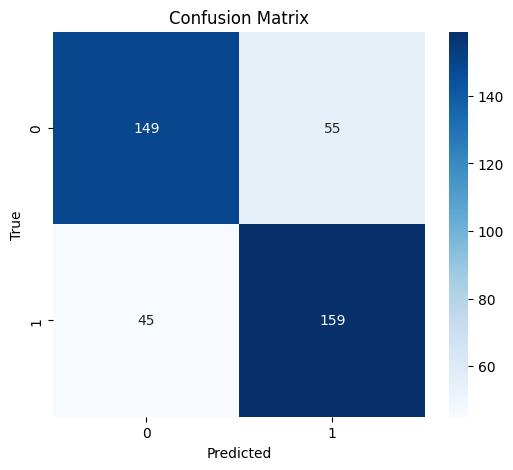


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7663    0.7595    0.7629       341
           1     0.7616    0.7683    0.7650       341

    accuracy                         0.7639       682
   macro avg     0.7640    0.7639    0.7639       682
weighted avg     0.7640    0.7639    0.7639       682

Confusion Matrix:
 [[259  82]
 [ 79 262]]


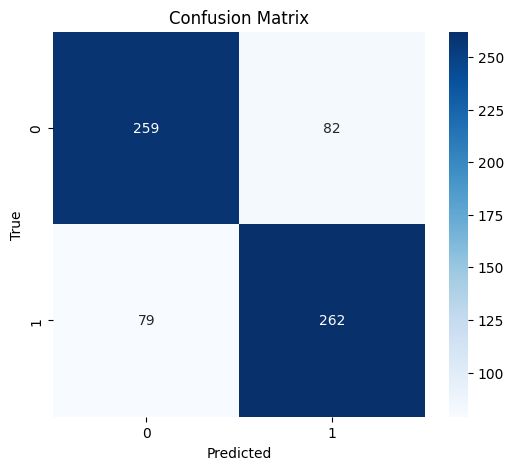


✅ Correct Example with Attention


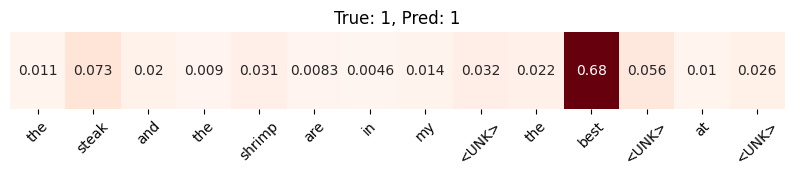


❌ Incorrect Example with Attention


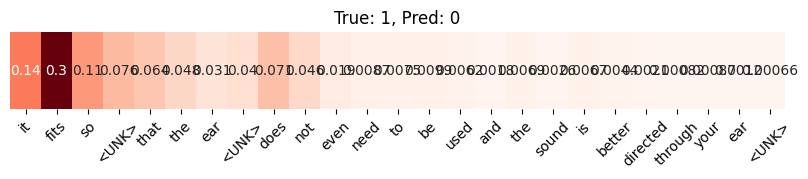

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def get_attention(model, dataloader, device):
    model.eval()
    all_weights, all_sentences, all_preds, all_labels = [], [], [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            embedded = model.embedding(x)
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            unpacked, _ = model.lstm(packed)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
            mask = (x != 0).float()
            context, weights = model.attention(lstm_out, mask)
            logits = model.fc(model.dropout(context))
            preds = torch.argmax(logits, dim=1)

            all_weights.extend(weights.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            all_sentences.extend(x.cpu().tolist())

    return all_sentences, all_weights, all_preds, all_labels

def visualize_attention(example_idx, sentences, weights, labels, preds, vocab):
    tokens = [vocab.idx2word.get(idx, "<UNK>") for idx in sentences[example_idx] if idx != 0]
    attention = weights[example_idx][:len(tokens)]

    plt.figure(figsize=(10, 1))
    sns.heatmap([attention], xticklabels=tokens, cmap="Reds", annot=True, cbar=False)
    plt.title(f"True: {labels[example_idx]}, Pred: {preds[example_idx]}")
    plt.yticks([])
    plt.xticks(rotation=45)
    plt.show()

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 15
    dropout = 0






    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

    sents, attns, preds, labels = get_attention(model, test_loader, device)
    for i in range(len(sents)):
        if preds[i] == labels[i]:
            print("\n✅ Correct Example with Attention")
            visualize_attention(i, sents, attns, labels, preds, vocab)
            break
    for i in range(len(sents)):
        if preds[i] != labels[i]:
            print("\n❌ Incorrect Example with Attention")
            visualize_attention(i, sents, attns, labels, preds, vocab)
            break

main()

# lr =5e-4


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 34.0381, Train Acc = 0.6628, Dev Acc = 0.7132
Epoch 2: Loss = 25.5262, Train Acc = 0.7729, Dev Acc = 0.7623
Epoch 3: Loss = 17.3982, Train Acc = 0.8684, Dev Acc = 0.7892
Epoch 4: Loss = 11.8186, Train Acc = 0.9125, Dev Acc = 0.7745
Epoch 5: Loss = 7.0480, Train Acc = 0.9627, Dev Acc = 0.7966
Epoch 6: Loss = 3.8592, Train Acc = 0.9835, Dev Acc = 0.7966
Epoch 7: Loss = 2.0802, Train Acc = 0.9927, Dev Acc = 0.7917
Epoch 8: Loss = 1.3175, Train Acc = 0.9957, Dev Acc = 0.8015
Epoch 9: Loss = 0.7382, Train Acc = 0.9994, Dev Acc = 0.7696
Epoch 10: Loss = 2.5386, Train Acc = 0.9890, Dev Acc = 0.7868
Epoch 11: Loss = 1.8110, Train Acc = 0.9908, Dev Acc = 0.7819
Epoch 12: Loss = 0.4923, Train Acc = 0.9994, Dev Acc = 0.7672
Epoch 13: Loss = 0.2886, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 14: Loss = 0.2114, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 15: Loss = 0.1544, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 16: Loss = 0.1418, Train Acc = 1.00

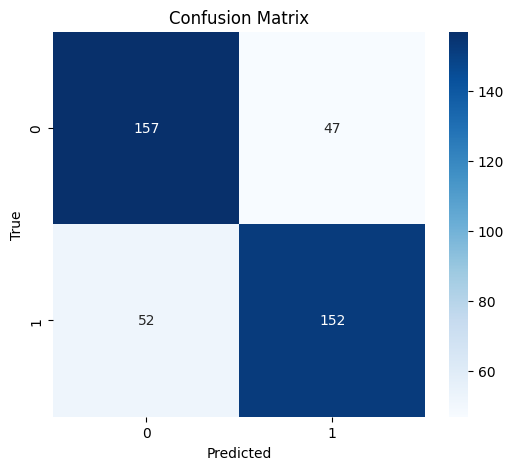


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7433    0.8152    0.7776       341
           1     0.7955    0.7185    0.7550       341

    accuracy                         0.7669       682
   macro avg     0.7694    0.7669    0.7663       682
weighted avg     0.7694    0.7669    0.7663       682

Confusion Matrix:
 [[278  63]
 [ 96 245]]


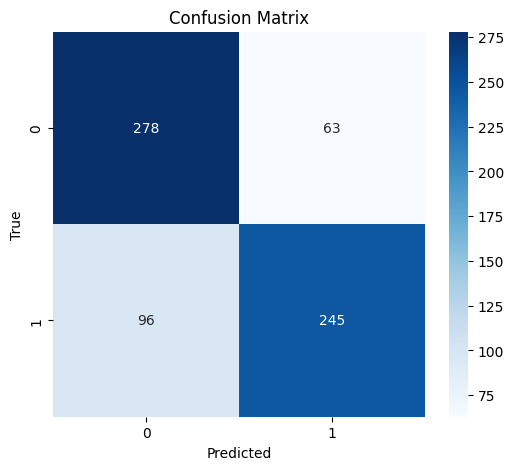

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# lr: 3e-4


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 35.2162, Train Acc = 0.6132, Dev Acc = 0.6961
Epoch 2: Loss = 31.6338, Train Acc = 0.7136, Dev Acc = 0.7328
Epoch 3: Loss = 24.8275, Train Acc = 0.7821, Dev Acc = 0.7525
Epoch 4: Loss = 18.4129, Train Acc = 0.8464, Dev Acc = 0.7794
Epoch 5: Loss = 12.7060, Train Acc = 0.9137, Dev Acc = 0.7696
Epoch 6: Loss = 9.7124, Train Acc = 0.9327, Dev Acc = 0.7696
Epoch 7: Loss = 6.7017, Train Acc = 0.9651, Dev Acc = 0.7598
Epoch 8: Loss = 4.8390, Train Acc = 0.9755, Dev Acc = 0.7598
Epoch 9: Loss = 3.3422, Train Acc = 0.9878, Dev Acc = 0.7647
Epoch 10: Loss = 2.4092, Train Acc = 0.9920, Dev Acc = 0.7475
Epoch 11: Loss = 1.6947, Train Acc = 0.9951, Dev Acc = 0.7377
Epoch 12: Loss = 1.2831, Train Acc = 0.9963, Dev Acc = 0.7426
Epoch 13: Loss = 0.9607, Train Acc = 0.9969, Dev Acc = 0.7304
Epoch 14: Loss = 0.8567, Train Acc = 0.9976, Dev Acc = 0.7892
Epoch 15: Loss = 0.9999, Train Acc = 0.9976, Dev Acc = 0.7672
Epoch 16: Loss = 0.7476, Train Acc = 0.9

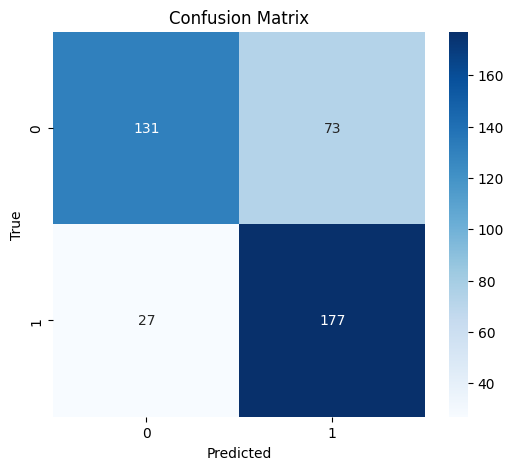


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8110    0.6041    0.6924       341
           1     0.6846    0.8592    0.7620       341

    accuracy                         0.7317       682
   macro avg     0.7478    0.7317    0.7272       682
weighted avg     0.7478    0.7317    0.7272       682

Confusion Matrix:
 [[206 135]
 [ 48 293]]


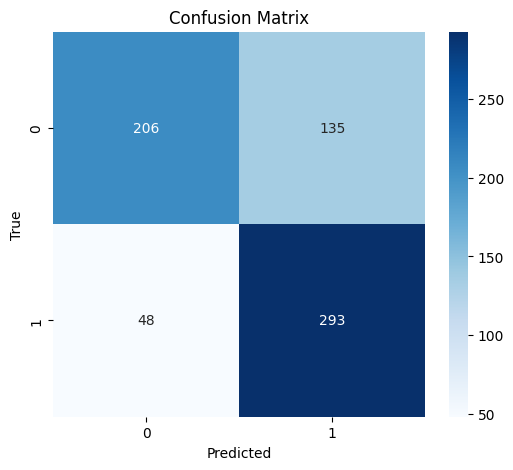

In [ ]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 3e-4
    epochs = 20
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
# the best lr :3e-4


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 35.9625, Train Acc = 0.5202, Dev Acc = 0.5711
Epoch 2: Loss = 35.6383, Train Acc = 0.6242, Dev Acc = 0.6446
Epoch 3: Loss = 35.2364, Train Acc = 0.6683, Dev Acc = 0.6740
Epoch 4: Loss = 34.9049, Train Acc = 0.6928, Dev Acc = 0.6765
Epoch 5: Loss = 34.3988, Train Acc = 0.7203, Dev Acc = 0.7034
Epoch 6: Loss = 33.6729, Train Acc = 0.7381, Dev Acc = 0.7010
Epoch 7: Loss = 32.8386, Train Acc = 0.7417, Dev Acc = 0.7108
Epoch 8: Loss = 31.7776, Train Acc = 0.7521, Dev Acc = 0.6985
Epoch 9: Loss = 30.5530, Train Acc = 0.7558, Dev Acc = 0.7132
Epoch 10: Loss = 29.1903, Train Acc = 0.7705, Dev Acc = 0.7279
Epoch 11: Loss = 26.6443, Train Acc = 0.7846, Dev Acc = 0.7426
Epoch 12: Loss = 25.0561, Train Acc = 0.8042, Dev Acc = 0.7402
Epoch 13: Loss = 23.1820, Train Acc = 0.8225, Dev Acc = 0.7623
Epoch 14: Loss = 21.7864, Train Acc = 0.8397, Dev Acc = 0.7647
Epoch 15: Loss = 20.0506, Train Acc = 0.8519, Dev Acc = 0.7721

📈 Evaluation on Dev Set:
    

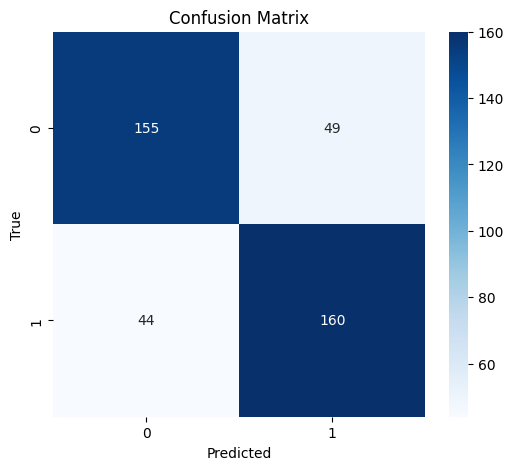


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7633    0.7566    0.7599       341
           1     0.7587    0.7654    0.7620       341

    accuracy                         0.7610       682
   macro avg     0.7610    0.7610    0.7610       682
weighted avg     0.7610    0.7610    0.7610       682

Confusion Matrix:
 [[258  83]
 [ 80 261]]


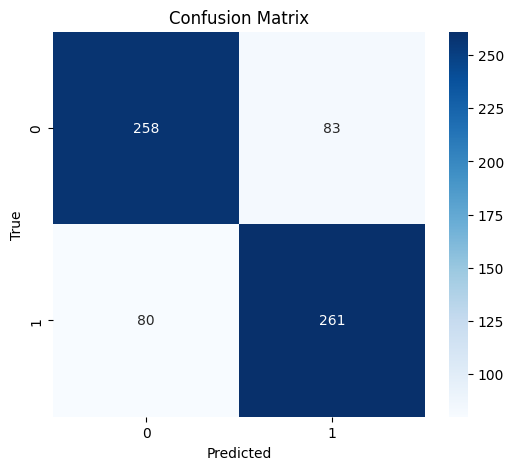

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 5e-5
    epochs = 15
    dropout = 0


    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


#  lr = 1e-3 ,epochs = 10


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 31.8313, Train Acc = 0.6799, Dev Acc = 0.7426
Epoch 2: Loss = 19.1989, Train Acc = 0.8397, Dev Acc = 0.7990
Epoch 3: Loss = 9.8940, Train Acc = 0.9382, Dev Acc = 0.7966
Epoch 4: Loss = 3.9459, Train Acc = 0.9792, Dev Acc = 0.8088
Epoch 5: Loss = 1.7895, Train Acc = 0.9908, Dev Acc = 0.8039
Epoch 6: Loss = 0.7864, Train Acc = 0.9969, Dev Acc = 0.7672
Epoch 7: Loss = 0.6895, Train Acc = 0.9963, Dev Acc = 0.7770
Epoch 8: Loss = 0.6400, Train Acc = 0.9969, Dev Acc = 0.7647
Epoch 9: Loss = 0.5527, Train Acc = 0.9976, Dev Acc = 0.7819
Epoch 10: Loss = 0.1112, Train Acc = 1.0000, Dev Acc = 0.7770

📈 Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7678    0.7941    0.7807       204
           1     0.7868    0.7598    0.7731       204

    accuracy                         0.7770       408
   macro avg     0.7773    0.7770    0.7769       408
weighted avg     0.7773    0.7770    0.7769       408



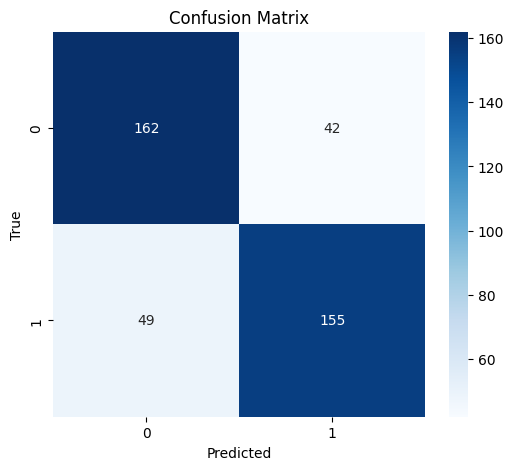


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7790    0.8065    0.7925       341
           1     0.7994    0.7713    0.7851       341

    accuracy                         0.7889       682
   macro avg     0.7892    0.7889    0.7888       682
weighted avg     0.7892    0.7889    0.7888       682

Confusion Matrix:
 [[275  66]
 [ 78 263]]


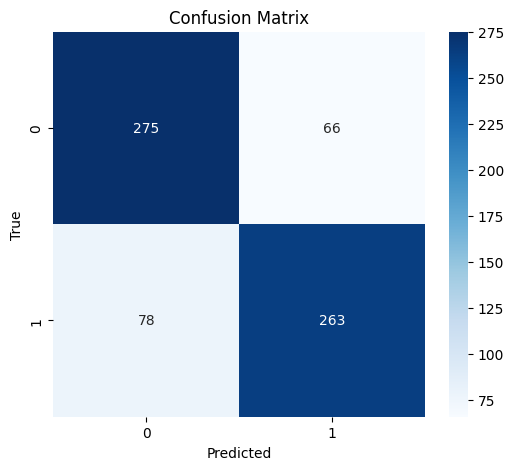

In [ ]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 10
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# lr = 1e-3 ,epochs = 20


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 31.3819, Train Acc = 0.6597, Dev Acc = 0.7574
Epoch 2: Loss = 20.2636, Train Acc = 0.8274, Dev Acc = 0.7990
Epoch 3: Loss = 9.4923, Train Acc = 0.9370, Dev Acc = 0.8064
Epoch 4: Loss = 4.0069, Train Acc = 0.9810, Dev Acc = 0.7892
Epoch 5: Loss = 1.9467, Train Acc = 0.9884, Dev Acc = 0.7966
Epoch 6: Loss = 0.6009, Train Acc = 0.9982, Dev Acc = 0.7941
Epoch 7: Loss = 0.2583, Train Acc = 1.0000, Dev Acc = 0.7892
Epoch 8: Loss = 0.1354, Train Acc = 1.0000, Dev Acc = 0.7745
Epoch 9: Loss = 0.0934, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 10: Loss = 0.0659, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 11: Loss = 0.0495, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 12: Loss = 0.0398, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 13: Loss = 0.0330, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 14: Loss = 0.0287, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 15: Loss = 0.0232, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 16: Loss = 0.0198, Train Acc = 1.0000

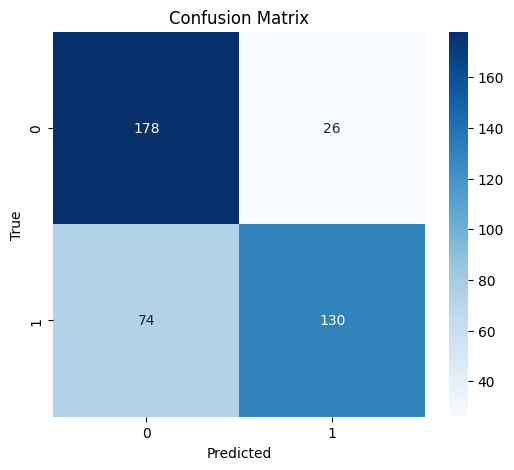


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6720    0.8592    0.7542       341
           1     0.8049    0.5806    0.6746       341

    accuracy                         0.7199       682
   macro avg     0.7384    0.7199    0.7144       682
weighted avg     0.7384    0.7199    0.7144       682

Confusion Matrix:
 [[293  48]
 [143 198]]


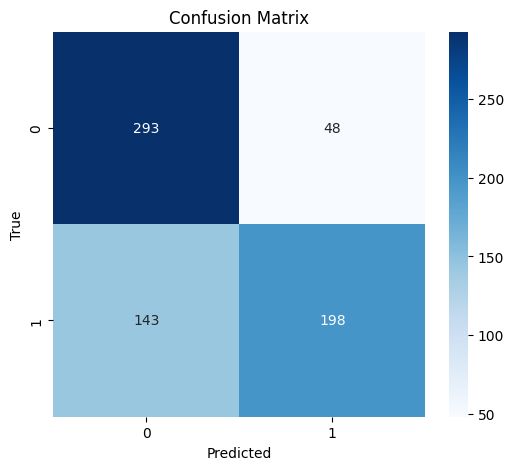

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# lr = 5e-4 ,epochs = 15


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 34.5394, Train Acc = 0.6230, Dev Acc = 0.6863
Epoch 2: Loss = 27.8728, Train Acc = 0.7625, Dev Acc = 0.7574
Epoch 3: Loss = 20.2384, Train Acc = 0.8599, Dev Acc = 0.7966
Epoch 4: Loss = 13.9723, Train Acc = 0.8966, Dev Acc = 0.8015
Epoch 5: Loss = 7.9106, Train Acc = 0.9535, Dev Acc = 0.8064
Epoch 6: Loss = 4.6736, Train Acc = 0.9823, Dev Acc = 0.8039
Epoch 7: Loss = 2.9724, Train Acc = 0.9896, Dev Acc = 0.7794
Epoch 8: Loss = 2.3413, Train Acc = 0.9920, Dev Acc = 0.7794
Epoch 9: Loss = 3.5061, Train Acc = 0.9804, Dev Acc = 0.7770
Epoch 10: Loss = 1.7646, Train Acc = 0.9939, Dev Acc = 0.7770
Epoch 11: Loss = 0.8332, Train Acc = 0.9976, Dev Acc = 0.7843
Epoch 12: Loss = 0.5479, Train Acc = 0.9994, Dev Acc = 0.7745
Epoch 13: Loss = 0.4125, Train Acc = 0.9994, Dev Acc = 0.7696
Epoch 14: Loss = 0.3329, Train Acc = 0.9994, Dev Acc = 0.7696
Epoch 15: Loss = 0.2584, Train Acc = 0.9994, Dev Acc = 0.7745

📈 Evaluation on Dev Set:
              p

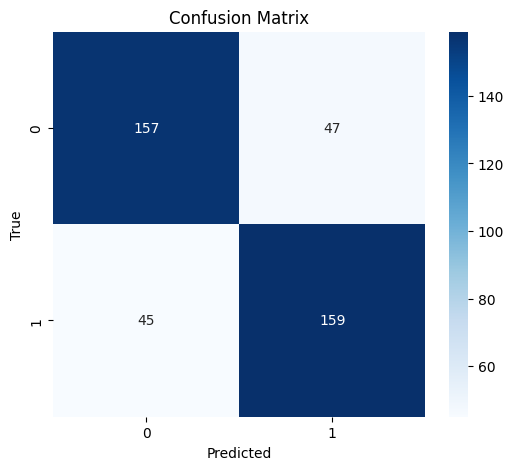


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7721    0.7947    0.7832       341
           1     0.7885    0.7654    0.7768       341

    accuracy                         0.7801       682
   macro avg     0.7803    0.7801    0.7800       682
weighted avg     0.7803    0.7801    0.7800       682

Confusion Matrix:
 [[271  70]
 [ 80 261]]


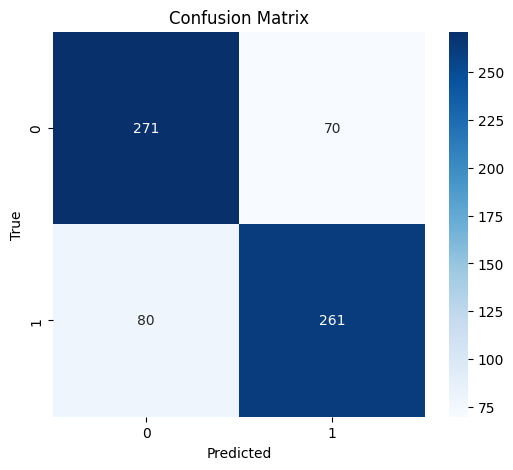

In [ ]:


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 15
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()



# lr = 1e-4 , epochs = 25


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 36.0379, Train Acc = 0.5092, Dev Acc = 0.6471
Epoch 2: Loss = 35.3340, Train Acc = 0.6579, Dev Acc = 0.7010
Epoch 3: Loss = 34.4518, Train Acc = 0.7154, Dev Acc = 0.7230
Epoch 4: Loss = 33.1295, Train Acc = 0.7405, Dev Acc = 0.7132
Epoch 5: Loss = 30.6963, Train Acc = 0.7472, Dev Acc = 0.7132
Epoch 6: Loss = 26.9966, Train Acc = 0.7791, Dev Acc = 0.7402
Epoch 7: Loss = 23.3324, Train Acc = 0.8054, Dev Acc = 0.7647
Epoch 8: Loss = 20.4972, Train Acc = 0.8360, Dev Acc = 0.7647
Epoch 9: Loss = 17.6956, Train Acc = 0.8721, Dev Acc = 0.7770
Epoch 10: Loss = 15.9615, Train Acc = 0.8911, Dev Acc = 0.7917
Epoch 11: Loss = 14.1187, Train Acc = 0.9051, Dev Acc = 0.7819
Epoch 12: Loss = 12.6060, Train Acc = 0.9192, Dev Acc = 0.7892
Epoch 13: Loss = 10.9852, Train Acc = 0.9339, Dev Acc = 0.7990
Epoch 14: Loss = 9.2367, Train Acc = 0.9425, Dev Acc = 0.7941
Epoch 15: Loss = 7.9267, Train Acc = 0.9541, Dev Acc = 0.7990
Epoch 16: Loss = 7.0821, Train A

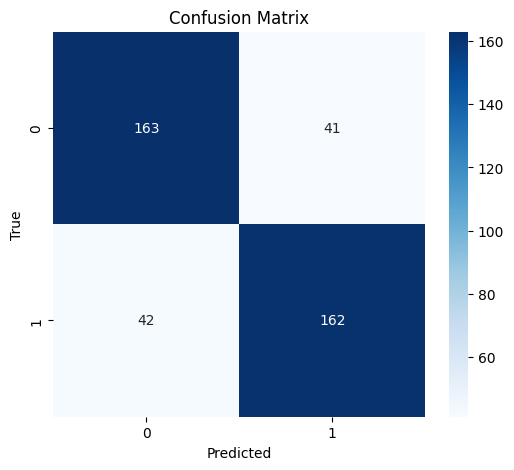


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7251    0.8123    0.7663       341
           1     0.7867    0.6921    0.7363       341

    accuracy                         0.7522       682
   macro avg     0.7559    0.7522    0.7513       682
weighted avg     0.7559    0.7522    0.7513       682

Confusion Matrix:
 [[277  64]
 [105 236]]


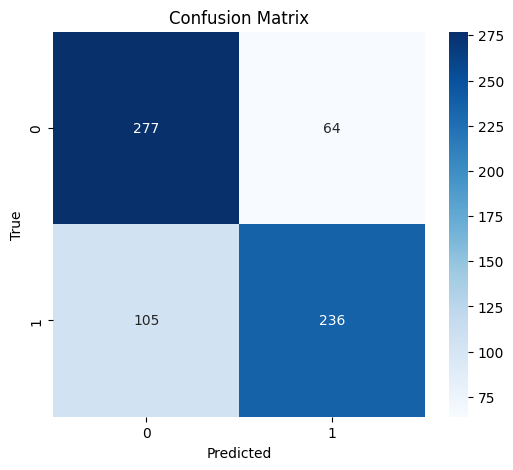

In [ ]:



import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-4
    epochs = 25
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()





🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 36.0679, Train Acc = 0.5080, Dev Acc = 0.5466
Epoch 2: Loss = 35.9791, Train Acc = 0.5312, Dev Acc = 0.5466
Epoch 3: Loss = 35.9266, Train Acc = 0.5490, Dev Acc = 0.5711
Epoch 4: Loss = 35.8832, Train Acc = 0.5826, Dev Acc = 0.6005
Epoch 5: Loss = 35.8093, Train Acc = 0.6077, Dev Acc = 0.6054
Epoch 6: Loss = 35.7637, Train Acc = 0.6346, Dev Acc = 0.6373
Epoch 7: Loss = 35.6998, Train Acc = 0.6475, Dev Acc = 0.6618
Epoch 8: Loss = 35.6424, Train Acc = 0.6610, Dev Acc = 0.6887
Epoch 9: Loss = 35.5868, Train Acc = 0.6756, Dev Acc = 0.7010
Epoch 10: Loss = 35.4784, Train Acc = 0.6946, Dev Acc = 0.7083
Epoch 11: Loss = 35.4474, Train Acc = 0.7050, Dev Acc = 0.7132
Epoch 12: Loss = 35.3733, Train Acc = 0.7087, Dev Acc = 0.7157
Epoch 13: Loss = 35.2669, Train Acc = 0.7173, Dev Acc = 0.7255
Epoch 14: Loss = 35.2618, Train Acc = 0.7240, Dev Acc = 0.7206
Epoch 15: Loss = 35.2001, Train Acc = 0.7240, Dev Acc = 0.7206
Epoch 16: Loss = 35.0855, Trai

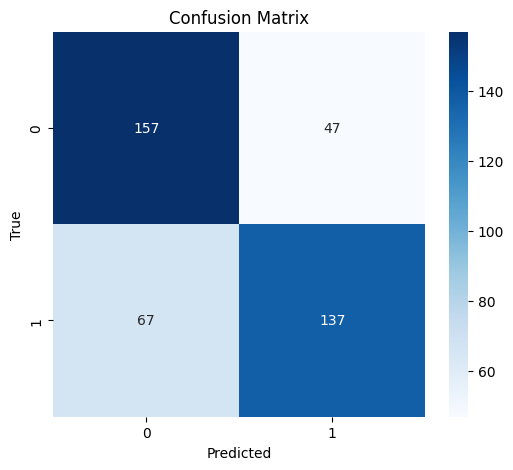


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6971    0.7830    0.7376       341
           1     0.7525    0.6598    0.7031       341

    accuracy                         0.7214       682
   macro avg     0.7248    0.7214    0.7203       682
weighted avg     0.7248    0.7214    0.7203       682

Confusion Matrix:
 [[267  74]
 [116 225]]


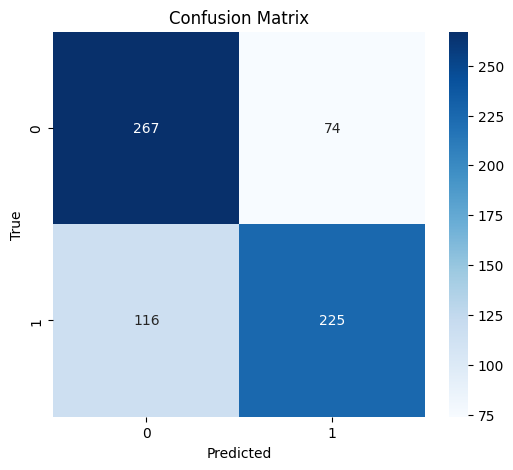

In [ ]:



import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-5
    epochs = 30
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()





🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 35.8905, Train Acc = 0.5116, Dev Acc = 0.4975
Epoch 2: Loss = 35.9641, Train Acc = 0.5129, Dev Acc = 0.4975
Epoch 3: Loss = 35.9027, Train Acc = 0.5135, Dev Acc = 0.4975
Epoch 4: Loss = 35.8676, Train Acc = 0.5135, Dev Acc = 0.4975
Epoch 5: Loss = 35.9346, Train Acc = 0.5135, Dev Acc = 0.4975
Epoch 6: Loss = 35.9247, Train Acc = 0.5141, Dev Acc = 0.5000
Epoch 7: Loss = 35.8733, Train Acc = 0.5147, Dev Acc = 0.5025
Epoch 8: Loss = 35.8733, Train Acc = 0.5147, Dev Acc = 0.5025
Epoch 9: Loss = 35.9169, Train Acc = 0.5147, Dev Acc = 0.5098
Epoch 10: Loss = 35.8839, Train Acc = 0.5159, Dev Acc = 0.5098
Epoch 11: Loss = 35.8721, Train Acc = 0.5159, Dev Acc = 0.5098
Epoch 12: Loss = 35.9359, Train Acc = 0.5159, Dev Acc = 0.5098
Epoch 13: Loss = 35.8983, Train Acc = 0.5159, Dev Acc = 0.5147
Epoch 14: Loss = 35.8499, Train Acc = 0.5171, Dev Acc = 0.5147
Epoch 15: Loss = 35.8842, Train Acc = 0.5165, Dev Acc = 0.5147
Epoch 16: Loss = 35.8905, Trai

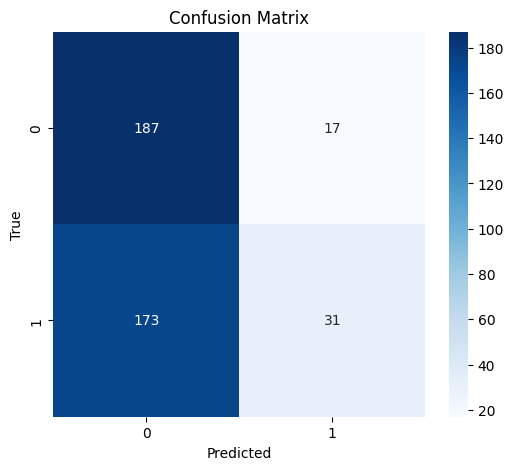


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.5272    0.9384    0.6751       341
           1     0.7200    0.1584    0.2596       341

    accuracy                         0.5484       682
   macro avg     0.6236    0.5484    0.4674       682
weighted avg     0.6236    0.5484    0.4674       682

Confusion Matrix:
 [[320  21]
 [287  54]]


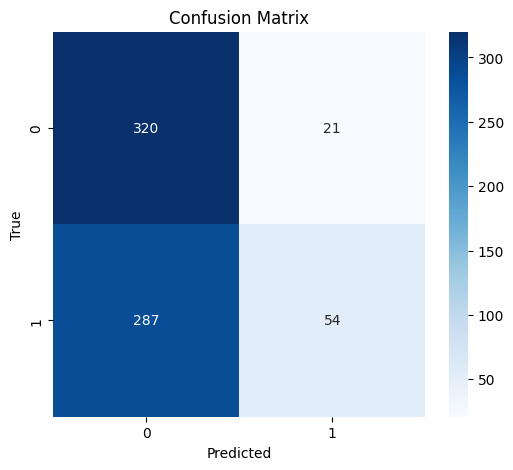

In [ ]:



import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr =0.0000005
    epochs = 50
    dropout = 0

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n🚀 Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n📈 Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


